In [1]:
# %pip install torch==2.3.1 --index-url https://download.pytorch.org/whl/test/cu121

In [2]:
# %pip install lightgbm xgboost scikit-learn pandas numpy matplotlib seaborn cvxpy pybind11 riskfolio-lib yfinance scikit-optimize scipy shap stable-baselines3 tqdm

In [1]:
# 5 hour [DONE] detect overfitting in XGboost model
# 5 hour [DONE] more analysis on final results performance. And frequency of MPM choosing HRP/ERC 
# 3 hour [DONE] more analysis on feature importance, and how it affects MPM choice
# 2 hour [done] consider MAPE of sharpe ratio, and it spred.
# 3 hour [DONE] use SHAP values to explain feature importance
# 3 hour [TODO] consider using a lightgbm model, and catboost model
# 1 day [DONE] change to backtesting framework, and add transaction costs
# 1 day [DONE] consider using a different risk measure, like CVaR
# 1 day [done] add lag features
# 3 day [DONE] add more strategies and more frequency of rebalancing (daily, weekly, monthly)
# 1 day [DONE] add continuous portfolios weighting (not just 100% in one portfolio)
# 3 day [TODO] compare to direct investment in the index itself
# 3 day [TODO] optimize the prediction sharpe ratio different to reduce the turnover rate

# 21 days: project total 
# 2 days [TODO] create a poster
# 4 days [TODO] create a presentation
# 12 days: presentation and poster total
# 34 days: project total

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from warnings import filterwarnings
import pandas as pd
import shap
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pickle as pkl
from main_utility_functions import *
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr, spearmanr
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import pandas as pd
import dice_ml
from dice_ml import Dice
from xgboost import XGBRegressor, XGBRanker

filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=RuntimeWarning)
filterwarnings("ignore", category=UserWarning)

d:\4 Projects\Meta_portfolio\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


#load data from gathered from main_build_data
with open('data_all.pkl','rb') as f:  #rb is read binary code
    cov_period, index_, returns = pkl.load(f)

# returns = returns[['EFA', 'EWJ', 'IWM', 'SPY', 'XLY']] #.iloc[:500] 
#basically convert all of returns to integer index
index_int=[x for x in range(len(returns.index))]
    
'''
IMPT VARIABLES:
    returns: a dataframe containing daily returns for each asset
    
    index_: Since features like semi_HRP requires measuring recent performance of hrp,
            2 diff daily portfolio returns are computed for hrp and erc where each hrp and erc is rebalanced monthly
            index_ decides when erc/hrp weights are applied (rebalancing)
            contains the INTEGER INDEX of the start of EVERY MONTH
    index_int: defines when weights and datapoints exists, contains the INTEGER INDEX of EVERY DAY
    index_trng: defines when MPM REBALANCING/STRATEGY CHOOSING occurs, contains INTEGER INDEX of month start, aft a period
                this is basically index_ but accounting for perf_period, sharpe_period, trng_period
    
    cov_period: defines the length of time backwards to compute weights and correlation matrix
    perf_period: defines the length of time that ret_b (returns backwards) calculates for performance features,
                and stats of assets universe
    sharpe_period: defines the length of time that ret_f(returns forwards) calcs for sharpe ratio
    trng_period: decides the number of data points and length of time considered for training
    
    weights_ERC: a dictionary containing weights for ERC, each set of weights is a Series indexed by assets
    weights_HRP: '' but for HRP

the dataframe.iloc[k:n] method acts like range and excludes n
the dataframe.loc[k:n] DOES NOT ACT like range, it INCLUDES n!!
'''

"\nIMPT VARIABLES:\n    returns: a dataframe containing daily returns for each asset\n    \n    index_: Since features like semi_HRP requires measuring recent performance of hrp,\n            2 diff daily portfolio returns are computed for hrp and erc where each hrp and erc is rebalanced monthly\n            index_ decides when erc/hrp weights are applied (rebalancing)\n            contains the INTEGER INDEX of the start of EVERY MONTH\n    index_int: defines when weights and datapoints exists, contains the INTEGER INDEX of EVERY DAY\n    index_trng: defines when MPM REBALANCING/STRATEGY CHOOSING occurs, contains INTEGER INDEX of month start, aft a period\n                this is basically index_ but accounting for perf_period, sharpe_period, trng_period\n    \n    cov_period: defines the length of time backwards to compute weights and correlation matrix\n    perf_period: defines the length of time that ret_b (returns backwards) calculates for performance features,\n                and

In [4]:
assets = ["AGG", "GLD", "LQD", "QQQ", "TIP", "VBR"]
returns = returns[assets]

# returns.dropna().corr().style.background_gradient(cmap='coolwarm', vmin = -1, vmax = 1).format("{:.2f}")

In [5]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats


def estimated_sharpe_ratio(returns):
    """
    Calculate the estimated sharpe ratio (risk_free=0).

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame

    Returns
    -------
    float, pd.Series
    """
    return returns.mean() / returns.std(ddof=1)


def ann_estimated_sharpe_ratio(returns=None, periods=261, *, sr=None):
    """
    Calculate the annualized estimated sharpe ratio (risk_free=0).

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame

    periods: int
        How many items in `returns` complete a Year.
        If returns are daily: 261, weekly: 52, monthly: 12, ...

    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio to be annualized, it's frequency must be coherent with `periods`

    Returns
    -------
    float, pd.Series
    """
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    sr = sr * np.sqrt(periods)
    return sr


def estimated_sharpe_ratio_stdev(returns=None, *, n=None, skew=None, kurtosis=None, sr=None):
    """
    Calculate the standard deviation of the sharpe ratio estimation.

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass the other 4 parameters.

    n: int
        Number of returns samples used for calculating `skew`, `kurtosis` and `sr`.

    skew: float, np.array, pd.Series, pd.DataFrame
        The third moment expressed in the same frequency as the other parameters.
        `skew`=0 for normal returns.

    kurtosis: float, np.array, pd.Series, pd.DataFrame
        The fourth moment expressed in the same frequency as the other parameters.
        `kurtosis`=3 for normal returns.

    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.

    Returns
    -------
    float, pd.Series

    Notes
    -----
    This formula generalizes for both normal and non-normal returns.
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if type(returns) != pd.DataFrame:
        _returns = pd.DataFrame(returns)
    else:
        _returns = returns.copy()

    if n is None:
        n = len(_returns)
    if skew is None:
        skew = pd.Series(scipy_stats.skew(_returns), index=_returns.columns)
    if kurtosis is None:
        kurtosis = pd.Series(scipy_stats.kurtosis(_returns, fisher=False), index=_returns.columns)
    if sr is None:
        sr = estimated_sharpe_ratio(_returns)

    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))

    if type(returns) == pd.DataFrame:
        sr_std = pd.Series(sr_std, index=returns.columns)
    elif type(sr_std) not in (float, np.float64, pd.DataFrame):
        sr_std = sr_std.values[0]

    return sr_std


def probabilistic_sharpe_ratio(returns=None, sr_benchmark=0.0, *, sr=None, sr_std=None):
    """
    Calculate the Probabilistic Sharpe Ratio (PSR).

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.

    sr_benchmark: float
        Benchmark sharpe ratio expressed in the same frequency as the other parameters.
        By default set to zero (comparing against no investment skill).

    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.

    sr_std: float, np.array, pd.Series, pd.DataFrame
        Standard deviation fo the Estimated sharpe ratio,
        expressed in the same frequency as the other parameters.

    Returns
    -------
    float, pd.Series

    Notes
    -----
    PSR(SR*) = probability that SR^ > SR*
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR* = `sr_benchmark`

    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    psr = scipy_stats.norm.cdf((sr - sr_benchmark) / sr_std)

    if type(returns) == pd.DataFrame:
        psr = pd.Series(psr, index=returns.columns)
    elif type(psr) not in (float, np.float64):
        psr = psr[0]

    return psr


def min_track_record_length(returns=None, sr_benchmark=0.0, prob=0.95, *, n=None, sr=None, sr_std=None):
    """
    Calculate the MIn Track Record Length (minTRL).

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.

    sr_benchmark: float
        Benchmark sharpe ratio expressed in the same frequency as the other parameters.
        By default set to zero (comparing against no investment skill).

    prob: float
        Confidence level used for calculating the minTRL.
        Between 0 and 1, by default=0.95

    n: int
        Number of returns samples used for calculating `sr` and `sr_std`.

    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.

    sr_std: float, np.array, pd.Series, pd.DataFrame
        Standard deviation fo the Estimated sharpe ratio,
        expressed in the same frequency as the other parameters.

    Returns
    -------
    float, pd.Series

    Notes
    -----
    minTRL = minimum of returns/samples needed (with same SR and SR_STD) to accomplish a PSR(SR*) > `prob`
    PSR(SR*) = probability that SR^ > SR*
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR* = `sr_benchmark`

    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if n is None:
        n = len(returns)
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    min_trl = 1 + (sr_std ** 2 * (n - 1)) * (scipy_stats.norm.ppf(prob) / (sr - sr_benchmark)) ** 2

    if type(returns) == pd.DataFrame:
        min_trl = pd.Series(min_trl, index=returns.columns)
    elif type(min_trl) not in (float, np.float64):
        min_trl = min_trl[0]

    return min_trl


def num_independent_trials(trials_returns=None, *, m=None, p=None):
    """
    Calculate the number of independent trials.
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    m: int
        Number of total trials.
        
    p: float
        Average correlation between all the trials.

    Returns
    -------
    int
    """
    if m is None:
        m = trials_returns.shape[1]
        
    if p is None:
        corr_matrix = trials_returns.corr()
        p = corr_matrix.values[np.triu_indices_from(corr_matrix.values,1)].mean()
        
    n = p + (1 - p) * m
    
    n = int(n)+1  # round up
    
    return n


def expected_maximum_sr(trials_returns=None, expected_mean_sr=0.0, *, independent_trials=None, trials_sr_std=None):
    """
    Compute the expected maximum Sharpe ratio (Analytically)
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    expected_mean_sr: float
        Expected mean SR, usually 0. We assume that random startegies will have a mean SR of 0,
        expressed in the same frequency as the other parameters.
        
    independent_trials: int
        Number of independent trials, must be between 1 and `trials_returns.shape[1]`
        
    trials_sr_std: float
        Standard deviation fo the Estimated sharpe ratios of all trials,
        expressed in the same frequency as the other parameters.

    Returns
    -------
    float
    """
    emc = 0.5772156649 # Euler-Mascheroni constant
    
    if independent_trials is None:
        independent_trials = num_independent_trials(trials_returns)
    
    if trials_sr_std is None:
        srs = estimated_sharpe_ratio(trials_returns)
        trials_sr_std = srs.std()
    
    maxZ = (1 - emc) * scipy_stats.norm.ppf(1 - 1./independent_trials) + emc * scipy_stats.norm.ppf(1 - 1./(independent_trials * np.e))
    expected_max_sr = expected_mean_sr + (trials_sr_std * maxZ)
    
    return expected_max_sr


def deflated_sharpe_ratio(trials_returns=None, returns_selected=None, expected_mean_sr=0.0, *, expected_max_sr=None):
    """
    Calculate the Deflated Sharpe Ratio (PSR).

    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    returns_selected: pd.Series

    expected_mean_sr: float
        Expected mean SR, usually 0. We assume that random startegies will have a mean SR of 0,
        expressed in the same frequency as the other parameters.
        
    expected_max_sr: float
        The expected maximum sharpe ratio expected after running all the trials,
        expressed in the same frequency as the other parameters.

    Returns
    -------
    float

    Notes
    -----
    DFS = PSR(SR⁰) = probability that SR^ > SR⁰
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR⁰ = `max_expected_sr`

    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2460551
    """
    if expected_max_sr is None:
        expected_max_sr = expected_maximum_sr(trials_returns, expected_mean_sr)
        
    dsr = probabilistic_sharpe_ratio(returns=returns_selected, sr_benchmark=expected_max_sr)

    return dsr




In [6]:
r"""Python for Random Matrix Theory. This package implements several 
cleaning schemes for noisy correlation matrices, including 
the optimal shrinkage, rotationally-invariant estimator
to an underlying correlation matrix (as proposed by Joel Bun, 
Jean-Philippe Bouchaud, Marc Potters and colleagues).

Such cleaned correlation matrix are known to improve factor-decomposition
via Principal Component Analysis (PCA) and could be of relevance in a variety 
of contexts, including computational biology.

Cleaning schemes also result in much improved out-of-sample risk
of Markowitz optimal portfolios, as established over the years
in several papers by Jean-Philippe Bouchaud, Marc Potters and collaborators.

Some cleaning schemes can be easily adapted from the various shrinkage
estimators implemented in the sklearn.covariance module 
(see the various publications by O. Ledoit and M. Wolf listed below).

In addition, it might make sense to perform an empirical estimate
of a correlation matrix robust to outliers before proceeding with
the cleaning schemes of the present module. Some of those robust estimates
have been implemented in the sklearn.covariance module as well. 


References
----------
* "DISTRIBUTION OF EIGENVALUES FOR SOME SETS OF RANDOM MATRICES",
  V. A. Marcenko and L. A. Pastur
  Mathematics of the USSR-Sbornik, Vol. 1 (4), pp 457-483
* "A well-conditioned estimator for large-dimensional covariance matrices",
  O. Ledoit and M. Wolf
  Journal of Multivariate Analysis, Vol. 88 (2), pp 365-411
* "Improved estimation of the covariance matrix of stock returns with "
  "an application to portfolio selection",
  O. Ledoit and M. Wolf
  Journal of Empirical Finance, Vol. 10 (5), pp 603-621
* "Financial Applications of Random Matrix Theory: a short review",
  J.-P. Bouchaud and M. Potters
  arXiv: 0910.1205 [q-fin.ST]
* "Eigenvectors of some large sample covariance matrix ensembles",
  O. Ledoit and S. Peche
  Probability Theory and Related Fields, Vol. 151 (1), pp 233-264
* "NONLINEAR SHRINKAGE ESTIMATION OF LARGE-DIMENSIONAL COVARIANCE MATRICES",
  O. Ledoit and M. Wolf
  The Annals of Statistics, Vol. 40 (2), pp 1024-1060 
* "Rotational invariant estimator for general noisy matrices",
  J. Bun, R. Allez, J.-P. Bouchaud and M. Potters
  arXiv: 1502.06736 [cond-mat.stat-mech]
* "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
  J. Bun, J.-P. Bouchaud and M. Potters
  arXiv: 1610.08104 [cond-mat.stat-mech]
* "Direct Nonlinear Shrinkage Estimation of Large-Dimensional Covariance Matrices (September 2017)", 
  O. Ledoit and M. Wolf https://ssrn.com/abstract=3047302 or http://dx.doi.org/10.2139/ssrn.3047302
 
"""

from __future__ import division, print_function
from builtins import reversed
from builtins import map, zip
from collections.abc import MutableSequence, Sequence
import copy
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings

import numpy as np
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler

def checkDesignMatrix(X):
    """
       Parameters
       ----------
       X: a matrix of shape (T, N), where T denotes the number
           of samples and N labels the number of features.
           If T < N, a warning is issued to the user, and the transpose
           of X is considered instead.

       Returns:
       T: type int

       N: type int

       transpose_flag: type bool
           Specify if the design matrix X should be transposed
           in view of having less rows than columns.       
    """
    
    try:
        assert isinstance(X, (np.ndarray))
    except AssertionError:
        raise TypeError("Input X must be a numpy array, pandas DataFrame, " + \
                        "pandas Series, or a mutable sequence.", UserWarning)

    X = np.asarray(X, dtype=float)
    X = np.atleast_2d(X)

    if X.shape[0] < X.shape[1]:
        warnings.warn("The Marcenko-Pastur distribution pertains to "
                      "the empirical covariance matrix of a random matrix X "
                      "of shape (T, N). It is assumed that the number of "
                      "samples T is assumed higher than the number of "
                      "features N. The transpose of the matrix X submitted "
                      "at input will be considered in the cleaning schemes "
                      "for the corresponding correlation matrix.", UserWarning)
        
        T, N = reversed(X.shape)
        transpose_flag = True
    else:
        T, N = X.shape
        transpose_flag = False
        
    return T, N, transpose_flag
        
        
def marcenkoPastur(X):
    """
       Parameter
       ---------
       X: random matrix of shape (T, N), with T denoting the number
           of samples, whereas N refers to the number of features.
           It is assumed that the variance of the elements of X
           has been normalized to unity.           

       Returns
       -------
       (lambda_min, lambda_max): type tuple
           Bounds to the support of the Marcenko-Pastur distribution
           associated to random matrix X.
       rho: type function
           The Marcenko-Pastur density.

       Reference
       ---------
       "DISTRIBUTION OF EIGENVALUES FOR SOME SETS OF RANDOM MATRICES",
       V. A. Marcenko and L. A. Pastur
       Mathematics of the USSR-Sbornik, Vol. 1 (4), pp 457-483
    """

    T, N, _ = checkDesignMatrix(X)
    q = N / float(T)

    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    def rho(x):
        ret = np.sqrt((lambda_max - x) * (x - lambda_min))
        ret /= 2 * np.pi * q * x
        return ret if lambda_min < x < lambda_max else 0.0

    return (lambda_min, lambda_max), rho


def clipped(X, alpha=None, return_covariance=False):
    """Clips the eigenvalues of an empirical correlation matrix E 
       in order to provide a cleaned estimator E_clipped of the 
       underlying correlation matrix.
       Proceeds by keeping the [N * alpha] top eigenvalues and shrinking
       the remaining ones by a trace-preserving constant 
       (i.e. Tr(E_clipped) = Tr(E)).

       Parameters
       ----------
       X: design matrix, of shape (T, N), where T denotes the number
           of samples (think measurements in a time series), while N
           stands for the number of features (think of stock tickers).

       alpha: type float or derived from numbers.Real (default: None)
           Parameter between 0 and 1, inclusive, determining the fraction
           to keep of the top eigenvalues of an empirical correlation matrix.

           If left unspecified, alpha is chosen so as to keep all the
           empirical eigenvalues greater than the upper limit of 
           the support to the Marcenko-Pastur spectrum. Indeed, such 
           eigenvalues can be considered as associated with some signal,
           whereas the ones falling inside the Marcenko-Pastur range
           should be considered as corrupted with noise and indistinguishable
           from the spectrum of the correlation of a random matrix.

           This ignores finite-size effects that make it possible
           for the eigenvalues to exceed the upper and lower edges
           defined by the Marcenko-Pastur spectrum (cf. a set of results
           revolving around the Tracy-Widom distribution)
           
       return_covariance: type bool (default: False)
           If set to True, compute the standard deviations of each individual
           feature across observations, clean the underlying matrix
           of pairwise correlations, then re-apply the standard
           deviations and return a cleaned variance-covariance matrix.

       Returns
       -------
       E_clipped: type numpy.ndarray, shape (N, N)
           Cleaned estimator of the true correlation matrix C underlying
           a noisy, in-sample estimate E (empirical correlation matrix
           estimated from X). This cleaned estimator proceeds through
           a simple eigenvalue clipping procedure (cf. reference below).
           
           If return_covariance=True, E_clipped corresponds to a cleaned 
           variance-covariance matrix.

       Reference
       ---------
       "Financial Applications of Random Matrix Theory: a short review",
       J.-P. Bouchaud and M. Potters
       arXiv: 0910.1205 [q-fin.ST]
    """

    try:
        if alpha is not None:
            assert isinstance(alpha, Real) and 0 <= alpha <= 1
            
        assert isinstance(return_covariance, bool)
    except AssertionError:
        raise ValueError("y must be a 1D array")
    
    T, N, transpose_flag = checkDesignMatrix(X)
    if transpose_flag:
        X = X.T
        
    if not return_covariance:
        X = StandardScaler(with_mean=False,
                           with_std=True).fit_transform(X)

    ec = EmpiricalCovariance(store_precision=False,
                             assume_centered=True)
    ec.fit(X)
    E = ec.covariance_
    
    if return_covariance:
        inverse_std = 1./np.sqrt(np.diag(E))
        E *= inverse_std
        E *= inverse_std.reshape(-1, 1)

    eigvals, eigvecs = np.linalg.eigh(E)
    eigvecs = eigvecs.T

    if alpha is None:
        (lambda_min, lambda_max), _ = marcenkoPastur(X)
        xi_clipped = np.where(eigvals >= lambda_max, eigvals, np.nan)
    else:
        xi_clipped = np.full(N, np.nan)
        threshold = int(ceil(alpha * N))
        if threshold > 0:
            xi_clipped[-threshold:] = eigvals[-threshold:]

    gamma = float(E.trace() - np.nansum(xi_clipped))
    gamma /= np.isnan(xi_clipped).sum()
    xi_clipped = np.where(np.isnan(xi_clipped), gamma, xi_clipped)

    E_clipped = np.zeros((N, N), dtype=float)
    for xi, eigvec in zip(xi_clipped, eigvecs):
        eigvec = eigvec.reshape(-1, 1)
        E_clipped += xi * eigvec.dot(eigvec.T)
        
    tmp = 1./np.sqrt(np.diag(E_clipped))
    E_clipped *= tmp
    E_clipped *= tmp.reshape(-1, 1)
    
    if return_covariance:
      std = 1./inverse_std
      E_clipped *= std
      E_clipped *= std.reshape(-1, 1)

    return E_clipped


def stieltjes(z, E):
    """
       Parameters
       ----------
       z: complex number
       E: square matrix

       Returns
       -------
       A complex number, the resolvent of square matrix E, 
       also known as its Stieltjes transform.

       Reference
       ---------
       "Financial Applications of Random Matrix Theory: a short review",
       J.-P. Bouchaud and M. Potters
       arXiv: 0910.1205 [q-fin.ST]
    """

    try:
        assert isinstance(z, Complex)
        
        assert isinstance(E, (np.ndarray))
        E = np.asarray(E, dtype=float)
        E = np.atleast_2d(E)
        assert E.shape[0] == E.shape[1]
    except AssertionError:
        raise ValueError("y must be a 1D array")

    N = E.shape[0]
    
    ret = z * np.eye(N, dtype=float) - E
    ret = np.trace(ret) / N

    return ret


def xiHelper(x, q, E):
    """Helper function to the rotationally-invariant, optimal shrinkage
       estimator of the true correlation matrix (implemented via function
       optimalShrinkage of the present module). 

       Parameters
       ----------
       x: type derived from numbers.Real
           Would typically be expected to be an eigenvalue from the
           spectrum of correlation matrix E. The present function
           can however handle an arbitrary floating-point number.

       q: type derived from numbers.Real
           The number parametrizing a Marcenko-Pastur spectrum.

       E: type numpy.ndarray
           Symmetric correlation matrix associated with the 
           Marcenko-Pastur parameter q specified above.

       Returns
       -------
       xi: type float
           Cleaned eigenvalue of the true correlation matrix C underlying
           the empirical correlation E (the latter being corrupted 
           with in-sample noise). This cleaned version is computed
           assuming no prior knowledge on the structure of the true
           eigenvectors (thereby leaving the eigenvectors of E unscathed). 

       References
       ----------
       * "Rotational invariant estimator for general noisy matrices",
         J. Bun, R. Allez, J.-P. Bouchaud and M. Potters
         arXiv: 1502.06736 [cond-mat.stat-mech]
       * "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
         J. Bun, J.-P. Bouchaud and M. Potters
         arXiv: 1610.08104 [cond-mat.stat-mech]
    """

    try:
        assert isinstance(x, Real)
        assert isinstance(q, Real)
        assert isinstance(E, np.ndarray) and E.shape[0] == E.shape[1]
        assert np.allclose(E.transpose(1, 0), E)
    except AssertionError:
        raise ValueError("y must be a 1D array")

    N = E.shape[0]
    
    z = x - 1j / np.sqrt(N)
    s = stieltjes(z, E)
    xi = x / abs(1 - q + q * z * s)**2

    return xi


def gammaHelper(x, q, N, lambda_N, inverse_wishart=False):
    """Helper function to optimalShrinkage function defined below.

       The eigenvalue to the cleaned estimator of a true correlation
       matrix are computed via the function xiHelper defined above in
       the module at hand. 
       
       It is known however that when N is not very large
       a systematic downward bias affects the xiHelper estimator for small
       eigenvalues of the noisy empirical correlation matrix. This bias
       can be heuristically corrected by computing
       xi_hat = xi_RIE * max(1, Gamma),
       with Gamma evaluated by the function gammaHelper herewith.

       Parameters
       ----------
       x: type float or any other type derived from numbers.Real
           Typically an eigenvalue from the spectrum of a sample
           estimate of the correlation matrix associated to some
           design matrix X. However, the present function supports
           any arbitrary floating-point number x at input.

       q: type derived from numbers.Real
           Parametrizes a Marcenko-Pastur spectrum.

       N: type derived from numbers.Integral
           Dimension of a correlation matrix whose debiased, 
           rotationally-invariant estimator is to be assessed via
           the function RIE (see below), of which the present function
           is a helper.

       lambda_N: type derived from numbers.Real
           Smallest eigenvalue from the spectrum of an empirical
           estimate to a correlation matrix.
        
       inverse_wishart: type bool default: False
            Wether to use inverse wishart regularization

       Returns
       ------
       Gamma: type float
           Upward correction factor for computing a debiased 
           rotationally-invariant estimator of a true underlying 
           correlation matrix. 

       Reference
       ---------
       "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
        J. Bun, J.-P. Bouchaud and M. Potters
        arXiv: 1610.08104 [cond-mat.stat-mech]
    """

    try:
        assert isinstance(x, Real)
        assert isinstance(q, Real)
        assert isinstance(N, Integral)
        assert isinstance(lambda_N, Real)
    except AssertionError:
        raise ValueError("y must be a 1D array")

    z = x - 1j / np.sqrt(N)
    
    lambda_plus = (1 + np.sqrt(q))**2
    lambda_plus /= (1 - np.sqrt(q))**2
    lambda_plus *= lambda_N
    sigma_2 = lambda_N / (1 - np.sqrt(q))**2

    # gmp defined below stands for the Stieltjes transform of the
    # rescaled Marcenko-Pastur density, evaluated at z
    gmp = z + sigma_2 * (q - 1) - np.sqrt((z - lambda_N) * (z - lambda_plus))
    gmp /= 2 * q * sigma_2 * z

    Gamma = abs(1 - q + q * z * gmp)**2
    Gamma *= sigma_2
    
    if inverse_wishart:
        kappa = 2 * lambda_N / ((1 - q - lambda_N) ** 2 - 4 * q * lambda_N)
        alpha_s = 1 / (1 + 2 * q * kappa)
        denom = x / (1 + alpha_s * (x - 1.))
        Gamma /= denom
    else: 
        Gamma /= x
    
    return Gamma


def optimalShrinkage(X, return_covariance=False, method='rie'):
    """This function computes a cleaned, optimal shrinkage, 
       rotationally-invariant estimator (RIE) of the true correlation 
       matrix C underlying the noisy, in-sample estimate 
       E = 1/T X * transpose(X)
       associated to a design matrix X of shape (T, N) (T measurements 
       and N features).

       One approach to getting a cleaned estimator that predates the
       optimal shrinkage, RIE estimator consists in inverting the 
       Marcenko-Pastur equation so as to replace the eigenvalues
       from the spectrum of E by an estimation of the true ones.

       This approach is known to be numerically-unstable, in addition
       to failing to account for the overlap between the sample eigenvectors
       and the true eigenvectors. How to compute such overlaps was first
       explained by Ledoit and Peche (cf. reference below). Their procedure
       was extended by Bun, Bouchaud and Potters, who also correct
       for a systematic downward bias in small eigenvalues.
       
       It is this debiased, optimal shrinkage, rotationally-invariant
       estimator that the function at hand implements.
       
       In addition to above method, this funtion also provides access to:  
       - The finite N regularization of the optimal RIE for small eigenvalues
         as provided in section 8.1 of [3] a.k.a the inverse wishart (IW) regularization.
       - The direct kernel method of O. Ledoit and M. Wolf in their 2017 paper [4]. 
         This is a direct port of their Matlab code.
        
         
       Parameters
       ----------
       X: design matrix, of shape (T, N), where T denotes the number
           of samples (think measurements in a time series), while N
           stands for the number of features (think of stock tickers).
           
       return_covariance: type bool (default: False)
           If set to True, compute the standard deviations of each individual
           feature across observations, clean the underlying matrix
           of pairwise correlations, then re-apply the standard
           deviations and return a cleaned variance-covariance matrix.
       
       method: type string, optional (default="rie")
           - If "rie" : optimal shrinkage in the manner of Bun & al.
            with no regularisation  
           - If "iw" : optimal shrinkage in the manner of Bun & al.
            with the so called Inverse Wishart regularization
           - If 'kernel': Direct kernel method of Ledoit  Wolf.

       Returns
       -------
       E_RIE: type numpy.ndarray, shape (N, N)
           Cleaned estimator of the true correlation matrix C. A sample
           estimator of C is the empirical covariance matrix E 
           estimated from X. E is corrupted by in-sample noise.
           E_RIE is the optimal shrinkage, rotationally-invariant estimator 
           (RIE) of C computed following the procedure of Joel Bun 
           and colleagues (cf. references below).
           
           If return_covariance=True, E_clipped corresponds to a cleaned
           variance-covariance matrix.

       References
       ----------
       1 "Eigenvectors of some large sample covariance matrix ensembles",
         O. Ledoit and S. Peche
         Probability Theory and Related Fields, Vol. 151 (1), pp 233-264
       2 "Rotational invariant estimator for general noisy matrices",
         J. Bun, R. Allez, J.-P. Bouchaud and M. Potters
         arXiv: 1502.06736 [cond-mat.stat-mech]
       3 "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
         J. Bun, J.-P. Bouchaud and M. Potters
         arXiv: 1610.08104 [cond-mat.stat-mech]
       4 "Direct Nonlinear Shrinkage Estimation of Large-Dimensional Covariance Matrices (September 2017)", 
         O. Ledoit and M. Wolf https://ssrn.com/abstract=3047302 or http://dx.doi.org/10.2139/ssrn.3047302
    """
    
    try:
        assert isinstance(return_covariance, bool)
    except AssertionError:
        raise ValueError("y must be a 1D array")

    T, N, transpose_flag = checkDesignMatrix(X)
    if transpose_flag:
        X = X.T
        
    if not return_covariance:
        X = StandardScaler(with_mean=False,
                           with_std=True).fit_transform(X)

    ec = EmpiricalCovariance(store_precision=False,
                             assume_centered=True)
    ec.fit(X)
    E = ec.covariance_
    
    if return_covariance:
        inverse_std = 1./np.sqrt(np.diag(E))
        E *= inverse_std
        E *= inverse_std.reshape(-1, 1)

    eigvals, eigvecs = np.linalg.eigh(E)
    eigvecs = eigvecs.T

    q = N / float(T)
    lambda_N = eigvals[0]  # The smallest empirical eigenvalue,
                           # given that the function used to compute
                           # the spectrum of a Hermitian or symmetric
                           # matrix - namely np.linalg.eigh - returns
                           # the eigenvalues in ascending order.
    lambda_hats = None
    
    if method != 'kernel':
        use_inverse_wishart = (method == 'iw')
        xis = map(lambda x: xiHelper(x, q, E), eigvals)
        Gammas = map(lambda x: gammaHelper(x, q, N, lambda_N, inverse_wishart=use_inverse_wishart), eigvals)
        xi_hats = map(lambda a, b: a * b if b > 1 else a, xis, Gammas)
        lambda_hats = xi_hats
    else:
         lambda_hats = directKernel(q, T, N, eigvals)
        
    E_RIE = np.zeros((N, N), dtype=float)
    for lambda_hat, eigvec in zip(lambda_hats, eigvecs):
        eigvec = eigvec.reshape(-1, 1)
        E_RIE += lambda_hat * eigvec.dot(eigvec.T)
        
    tmp = 1./np.sqrt(np.diag(E_RIE))
    E_RIE *= tmp
    E_RIE *= tmp.reshape(-1, 1)
    
    if return_covariance:
        std = 1./inverse_std
        E_RIE *= std
        E_RIE *= std.reshape(-1, 1)

    return E_RIE


def directKernel(q, T, N, eigvals):
    """This function computes a non linear shrinkage estimator of a covariance marix
       based on the spectral distribution of its eigenvalues and that of its Hilbert Tranform.
       This is an extension of Ledoit & Péché(2011).
       
       This is a port of the Matlab code provided by O. Ledoit and M .Wolf. This port 
       uses the Pool Adjacent Violators (PAV) algorithm by Alexandre Gramfort 
       (EMAP toolbox). See below for a Python implementation of PAV.
                
       Parameters
       ----------
       q: type derived from numbers.Real
           Ratio of N/T
           
       T: type derived from numbers.Integral
          Number of samples
    
       N: type derived from numbers.Integral
           Dimension of a correlation matrix
       
       eigvals: Vector of the covariance matrix eigenvalues
       
       Returns
       -------
       dhats: A vector of eigenvalues estimates
       
       References
       ----------
       * "Eigenvectors of some large sample covariance matrix ensembles",
         O. Ledoit and S. Peche (2011)
       * "Direct Nonlinear Shrinkage Estimation of Large-Dimensional Covariance Matrices (September 2017)", 
         O. Ledoit and M. Wolf https://ssrn.com/abstract=3047302 or http://dx.doi.org/10.2139/ssrn.3047302
    """
    
    # compute direct kernel estimator
    lambdas = eigvals[max(0, N - T):].T  # transpose to have a column vector
    
    h = np.power(T, -0.35)  # Equation (5.4)
    h_squared = h ** 2
    
    L = np.matlib.repmat(lambdas, N, 1).T
    Lt = L.transpose()
    square_Lt = h_squared * (Lt ** 2)
    
    zeros = np.zeros((N, N))
    
    tmp = np.sqrt(np.maximum(4 * square_Lt - (L - Lt) ** 2, zeros)) / (2 * np.pi * square_Lt)
    f_tilde = np.mean(tmp, axis=0)    # Equation (5.2)
    
    tmp = np.sign(L - Lt) * np.sqrt(np.maximum((L - Lt) ** 2 - 4 * square_Lt, zeros)) - L + Lt 
    tmp /= 2 * np.pi * square_Lt
    Hf_tilde = np.mean(tmp, axis=1)    # Equation (5.3)
    
    if N <= T:
        tmp = (np.pi * q * lambdas * f_tilde) ** 2
        tmp += (1 - q - np.pi * q * lambdas * Hf_tilde) ** 2
        d_tilde = lambdas / tmp    # Equation (4.3)
    else:
        Hf_tilde_0 = (1 - np.sqrt(1 - 4 * h_squared)) / (2 * np.pi * h_squared) * np.mean(1. / lambdas)  # Equation (C.8)
        d_tilde_0 = 1 / (np.pi * (N - T) / T * Hf_tilde_0)  # Equation (C.5)
        d_tilde_1 = lambdas / ((np.pi ** 2) * (lambdas ** 2) * (f_tilde ** 2 + Hf_tilde ** 2))  # Equation (C.4)
        d_tilde = np.concatenate(np.dot(d_tilde_0, np.ones(N - T, 1, np.float)), d_tilde_1)
        
    d_hats = poolAdjacentViolators(d_tilde) # Equation (4.5)
    
    return d_hats


# Author : Alexandre Gramfort
# license : BSD
def poolAdjacentViolators(y):
    """
    PAV uses the pool adjacent violators method to produce a monotonic smoothing of y.
    Translated from matlab by Sean Collins (2006), and part of the EMAP toolbox.
    """
    
    y = np.asarray(y)
    
    try:
        assert y.ndim == 1
    except AssertionError:
      raise ValueError("y must be a 1D array")
      
    n_samples = len(y)
    v = y.copy()
    lvls = np.arange(n_samples)
    lvlsets = np.c_[lvls, lvls]
    
    while True:
        deriv = np.diff(v)
        if np.all(deriv >= 0):
            break

        violator = np.where(deriv < 0)[0]
        start = lvlsets[violator[0], 0]
        last = lvlsets[violator[0] + 1, 1]
        s = 0
        n = last - start + 1
        for i in range(start, last + 1):
            s += v[i]

        val = s / n
        for i in range(start, last + 1):
            v[i] = val
            lvlsets[i, 0] = start
            lvlsets[i, 1] = last
            
    return v


In [7]:
# tmp_ret = returns.iloc[1:100]
# tmp_res = optimalShrinkage(tmp_ret, return_covariance=False, method='rie')
# pd.DataFrame(tmp_res).style.background_gradient(cmap='coolwarm', vmin = -1, vmax = 1).format("{:.2f}")

In [8]:
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import squareform
import riskfolio as rp
import riskfolio.src.RiskFunctions as rk
import riskfolio.src.AuxFunctions as af
import riskfolio.src.ParamsEstimation as pe
import riskfolio.src.DBHT as db
import riskfolio.src.GerberStatistic as gs
import numpy as np
import pandas as pd
import cvxpy as cp
import scipy.stats as st
from numpy.linalg import pinv
from scipy.linalg import sqrtm, norm, null_space
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import riskfolio.src.RiskFunctions as rk
import riskfolio.src.ParamsEstimation as pe
import riskfolio.src.AuxFunctions as af
import riskfolio.src.OwaWeights as owa
import riskfolio.external.cppfunctions as cf

class Portfolio_modify(rp.Portfolio):

    def assets_stats(
        self,
        method_mu="hist",
        method_cov="hist",
        method_kurt=None,
        dict_mu={},
        dict_cov={},
        dict_kurt={},
    ):
        r"""
        Calculate the inputs that will be used by the optimization method when
        we select the input model='Classic'.

        Parameters
        ----------
        method_mu : str, optional
            The method used to estimate the expected returns.
            The default value is 'hist'. Possible values are:

            - 'hist': use historical estimates.
            - 'ewma1'': use ewma with adjust=True, see `EWM <https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows>`_ for more details.
            - 'ewma2': use ewma with adjust=False, see `EWM <https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows>`_ for more details.
            - 'JS': James-Stein estimator. For more information see :cite:`a-Meucci2005` and :cite:`a-Feng2016`.
            - 'BS': Bayes-Stein estimator. For more information see :cite:`a-Jorion1986`.
            - 'BOP': BOP estimator. For more information see :cite:`a-Bodnar2019`.

        method_cov : str, optional
            The method used to estimate the covariance matrix.
            The default is 'hist'. Possible values are:

            - 'hist': use historical estimates.
            - 'ewma1'': use ewma with adjust=True, see `EWM <https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows>`_ for more details.
            - 'ewma2': use ewma with adjust=False, see `EWM <https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows>`_ for more details.
            - 'ledoit': use the Ledoit and Wolf Shrinkage method.
            - 'oas': use the Oracle Approximation Shrinkage method.
            - 'shrunk': use the basic Shrunk Covariance method.
            - 'gl': use the basic Graphical Lasso Covariance method.
            - 'jlogo': use the j-LoGo Covariance method. For more information see: :cite:`a-jLogo`.
            - 'fixed': denoise using fixed method. For more information see chapter 2 of :cite:`a-MLforAM`.
            - 'spectral': denoise using spectral method. For more information see chapter 2 of :cite:`a-MLforAM`.
            - 'shrink': denoise using shrink method. For more information see chapter 2 of :cite:`a-MLforAM`.
            - 'gerber1': use the Gerber statistic 1. For more information see: :cite:`a-Gerber2021`.
            - 'gerber2': use the Gerber statistic 2. For more information see: :cite:`a-Gerber2021`.

        method_kurt : str, optional
            The method used to estimate the kurtosis square matrix:
            The default is None. Possible values are:

            - None: do not calculate kurtosis square matrix.
            - 'hist': use historical estimates. For more information see :cite:`a-Cajas4`.
            - 'semi': use semi cokurtosis square matrix. For more information see :cite:`a-Cajas4`.
            - 'fixed': denoise using fixed method. For more information see chapter 2 of :cite:`a-MLforAM`.
            - 'spectral': denoise using spectral method. For more information see chapter 2 of :cite:`a-MLforAM`.
            - 'shrink': denoise using shrink method. For more information see chapter 2 of :cite:`a-MLforAM`.

        dict_mu : dict
            Other variables related to the mean vector estimation method.
        dict_cov : dict
            Other variables related to the covariance estimation method.
        dict_kurt : dict
            Other variables related to the cokurtosis estimation method.

        See Also
        --------
        riskfolio.src.ParamsEstimation.mean_vector
        riskfolio.src.ParamsEstimation.covar_matrix
        riskfolio.src.ParamsEstimation.cokurt_matrix

        """

        self.mu = pe.mean_vector(self.returns, method=method_mu, **dict_mu)
        if (method_cov == "custom_cov"):
            self.cov = dict_cov["cov"]
        else:
            self.cov = pe.covar_matrix(self.returns, method=method_cov, **dict_cov)

        value = af.is_pos_def(self.cov, threshold=1e-6)
        for i in range(5):
            if value == False:
                try:
                    self.cov = af.cov_fix(self.cov, method="clipped", threshold=1e-6)
                    value = af.is_pos_def(self.cov, threshold=1e-6)
                except:
                    break
            else:
                break

        if value == False:
            print("You must convert self.cov to a positive definite matrix")

        if method_kurt not in [None, "semi"]:
            T, N = self.returns.shape
            self.L_2 = cf.duplication_elimination_matrix(N)
            self.S_2 = cf.duplication_summation_matrix(N)
            self.kurt = pe.cokurt_matrix(self.returns, method=method_kurt, **dict_kurt)
            value = af.is_pos_def(self.kurt, threshold=1e-8)
            for i in range(5):
                if value == False:
                    try:
                        self.kurt = af.cov_fix(
                            self.kurt, method="clipped", threshold=1e-5
                        )
                        value = af.is_pos_def(self.kurt, threshold=1e-8)
                    except:
                        break
                else:
                    break

            if value == False:
                print("You must convert self.kurt to a positive definite matrix")

            self.skurt = pe.cokurt_matrix(self.returns, method="semi")
            value = af.is_pos_def(self.skurt, threshold=1e-6)
            for i in range(5):
                if value == False:
                    try:
                        self.skurt = af.cov_fix(
                            self.skurt, method="clipped", threshold=1e-6
                        )
                        value = af.is_pos_def(self.skurt, threshold=1e-6)
                    except:
                        break
                else:
                    break

            if value == False:
                print("You must convert self.skurt to a positive definite matrix")

        else:
            self.kurt = None
            self.skurt = None
            self.L_2 = None
            self.S_2 = None



class HCPortfolio_modify(rp.HCPortfolio):
    def _hierarchical_clustering(
            self,
            model="HRP",
            linkage="ward",
            codependence="pearson",
            opt_k_method="twodiff",
            k=None,
            max_k=10,
            leaf_order=True,
        ):
            # Calculating distance
            if codependence in {
                "pearson",
                "spearman",
                "kendall",
                "gerber1",
                "gerber2",
                "custom_cov",
            }:
                dist = np.sqrt(np.clip((1 - self.codep) / 2, a_min=0.0, a_max=1.0))
            elif codependence in {"abs_pearson", "abs_spearman", "abs_kendall", "distance"}:
                dist = np.sqrt(np.clip((1 - self.codep), a_min=0.0, a_max=1.0))
            elif codependence in {"mutual_info"}:
                dist = af.var_info_matrix(self.returns, self.bins_info).astype(float)
            elif codependence in {"tail"}:
                dist = -np.log(self.codep).astype(float)

            # Hierarchical clustering
            dist = dist.to_numpy()
            dist = pd.DataFrame(dist, columns=self.codep.columns, index=self.codep.index)
            if linkage == "DBHT":
                # different choices for D, S give different outputs!
                D = dist.to_numpy()  # dissimilarity matrix
                if codependence in {
                    "pearson",
                    "spearman",
                    "kendall",
                    "gerber1",
                    "gerber2",
                    "custom_cov",
                }:
                    codep = 1 - dist**2
                    S = codep.to_numpy()  # similarity matrix
                else:
                    S = self.codep.to_numpy()  # similarity matrix
                (_, _, _, _, _, clustering) = db.DBHTs(
                    D, S, leaf_order=leaf_order
                )  # DBHT clustering
            else:
                self.p_dist = squareform(dist, checks=False)
                clustering = hr.linkage(self.p_dist, method=linkage, optimal_ordering=leaf_order)

            if model in {"HERC", "HERC2", "NCO"}:
                # optimal number of clusters
                if k is None:
                    if opt_k_method == "twodiff":
                        k, _ = af.two_diff_gap_stat(dist, clustering, max_k)
                    elif opt_k_method == "stdsil":
                        k, _ = af.std_silhouette_score(dist, clustering, max_k)
                    else:
                        raise ValueError(
                            "The only opt_k_method available are twodiff and stdsil"
                        )
            else:
                k = None

            return clustering, k

In [9]:
'''PART 1: BUILD DAILY WEIGHTS, CORRELATION MATRIX FOR ERC AND HRP
For every day after the first year, build weights based on past year w/riskfolio
For each strategy and each day there is an associated corr matrix
'''

assets = returns.columns.tolist()

In [10]:
import joblib
res = joblib.load('test2_sum.pkl')

In [11]:
weights_port,corr,coph = {},{},{}
for i, port_dict, corr_, coph_ in sorted(res, key=lambda x: x[0]):
    weights_port[i] = port_dict
    corr[i] = corr_
    coph[i] = coph_

In [12]:
model_list = list(weights_port[list(weights_port.keys())[0]].keys())

In [13]:
c = 0
for main_key, i in weights_port.items():
    for k, v in i.items(): 
        if (type(v) == type(None)):
            c += 1
            weights_port[main_key][k] = past[k]
    past = i
print(c)

170


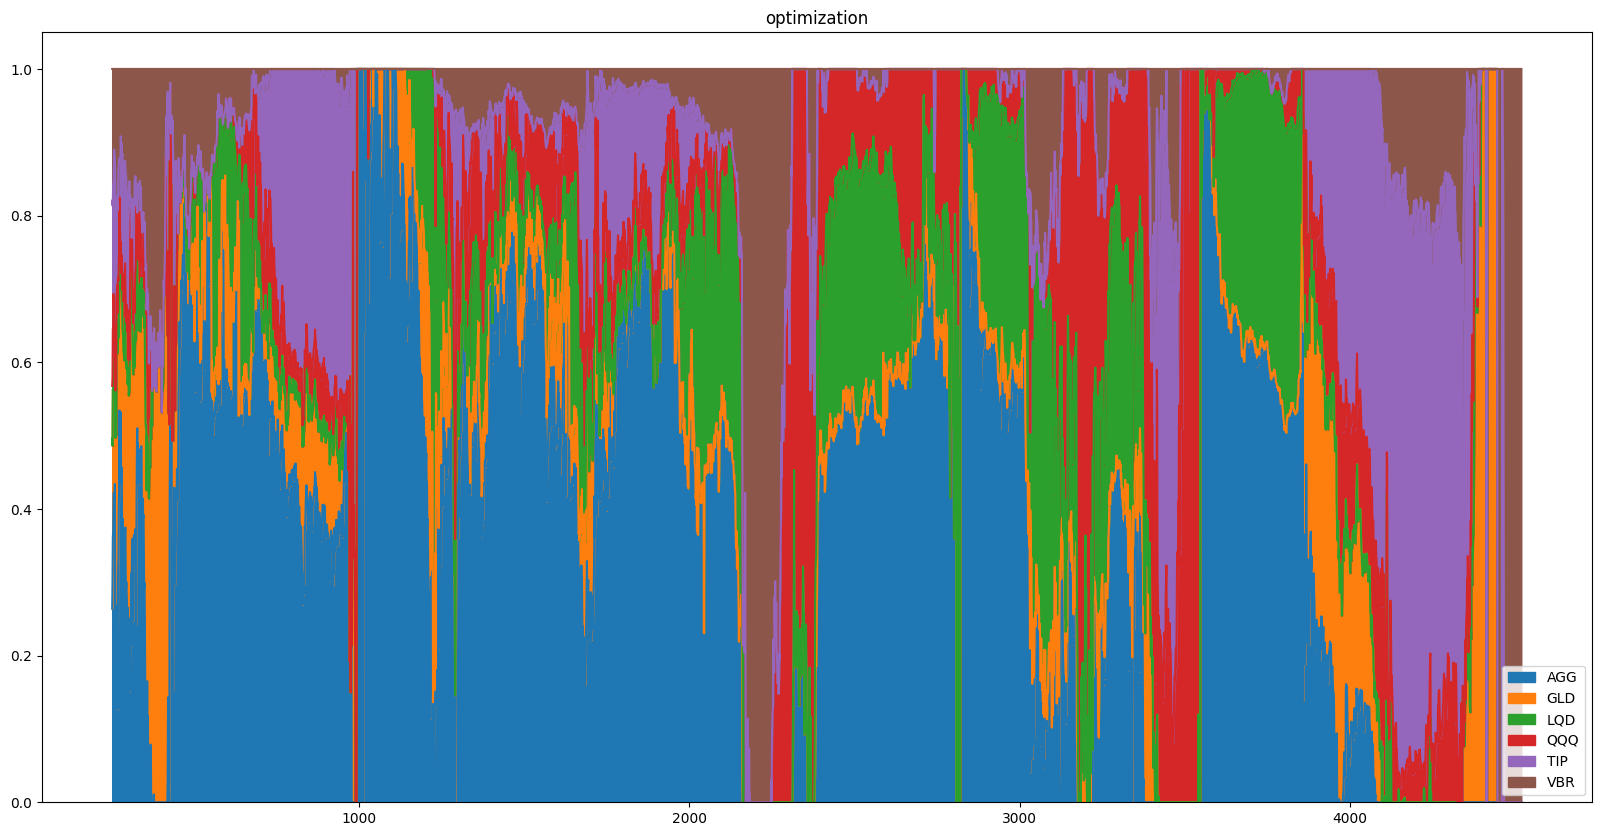

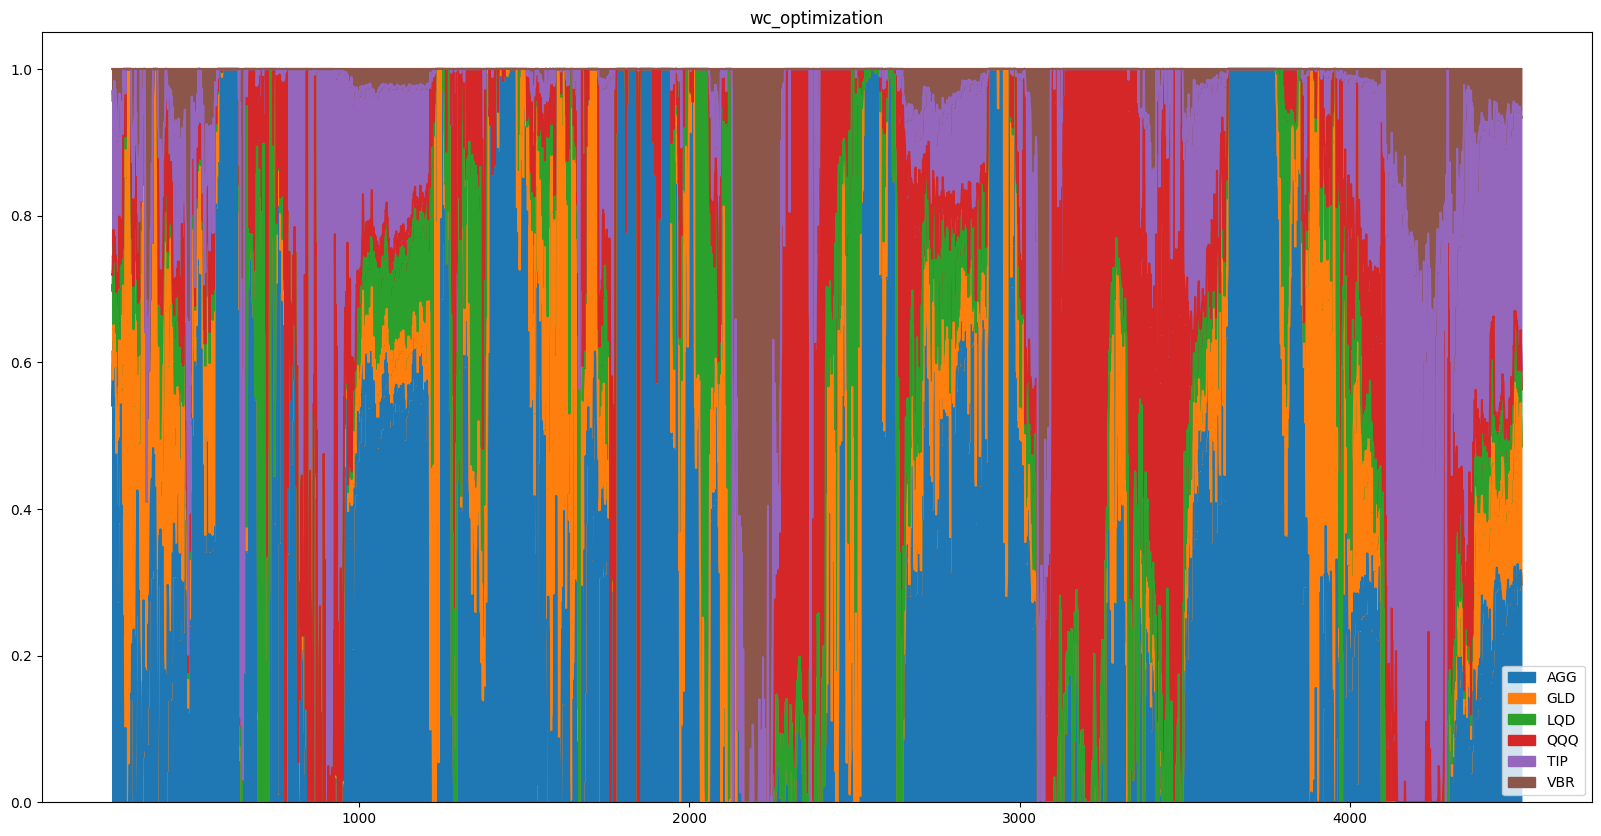

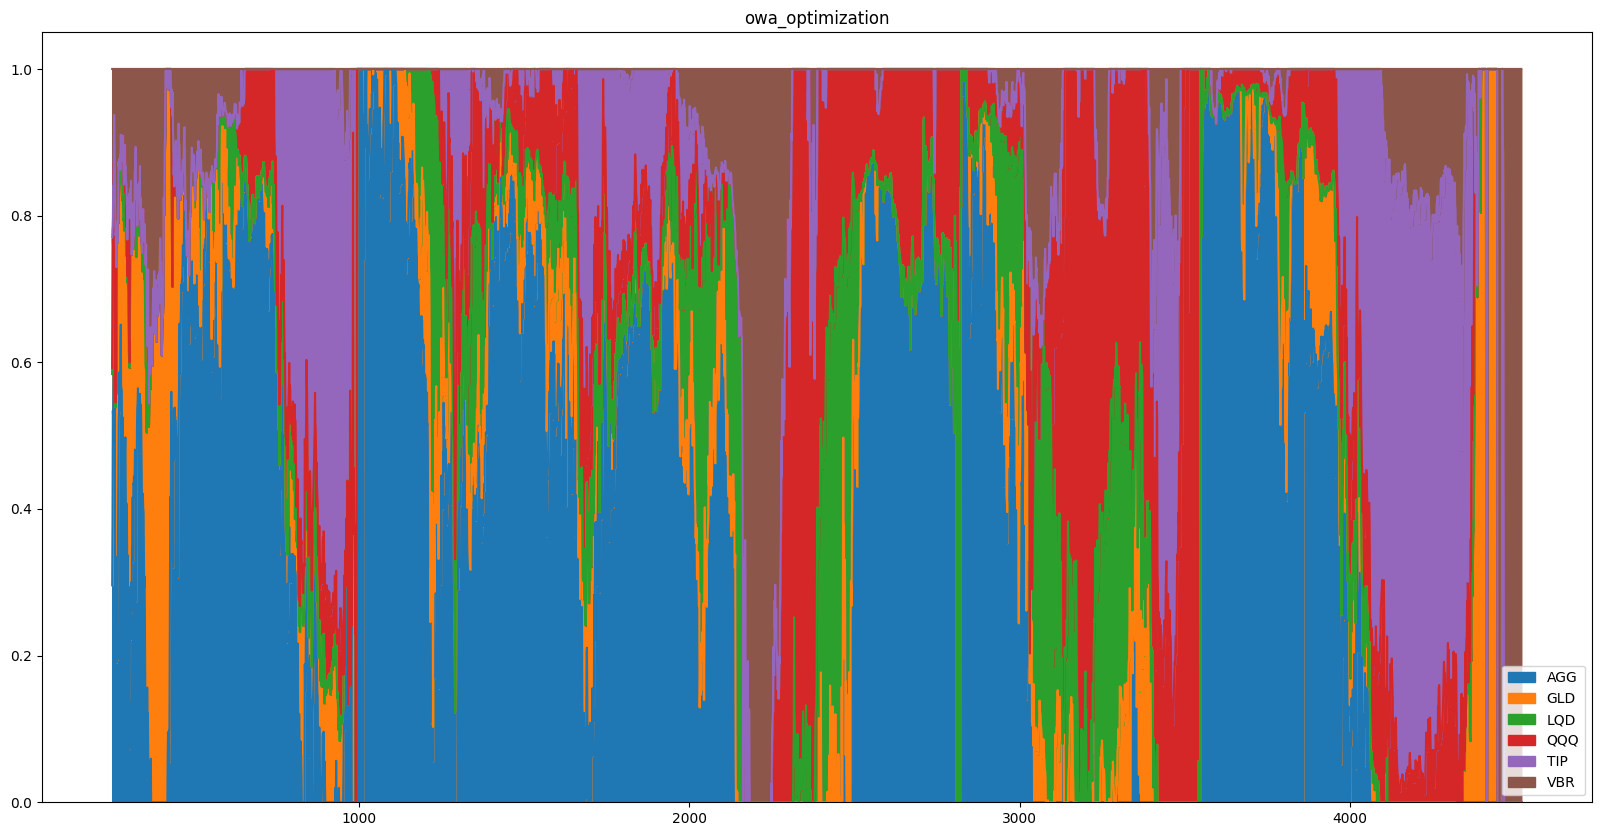

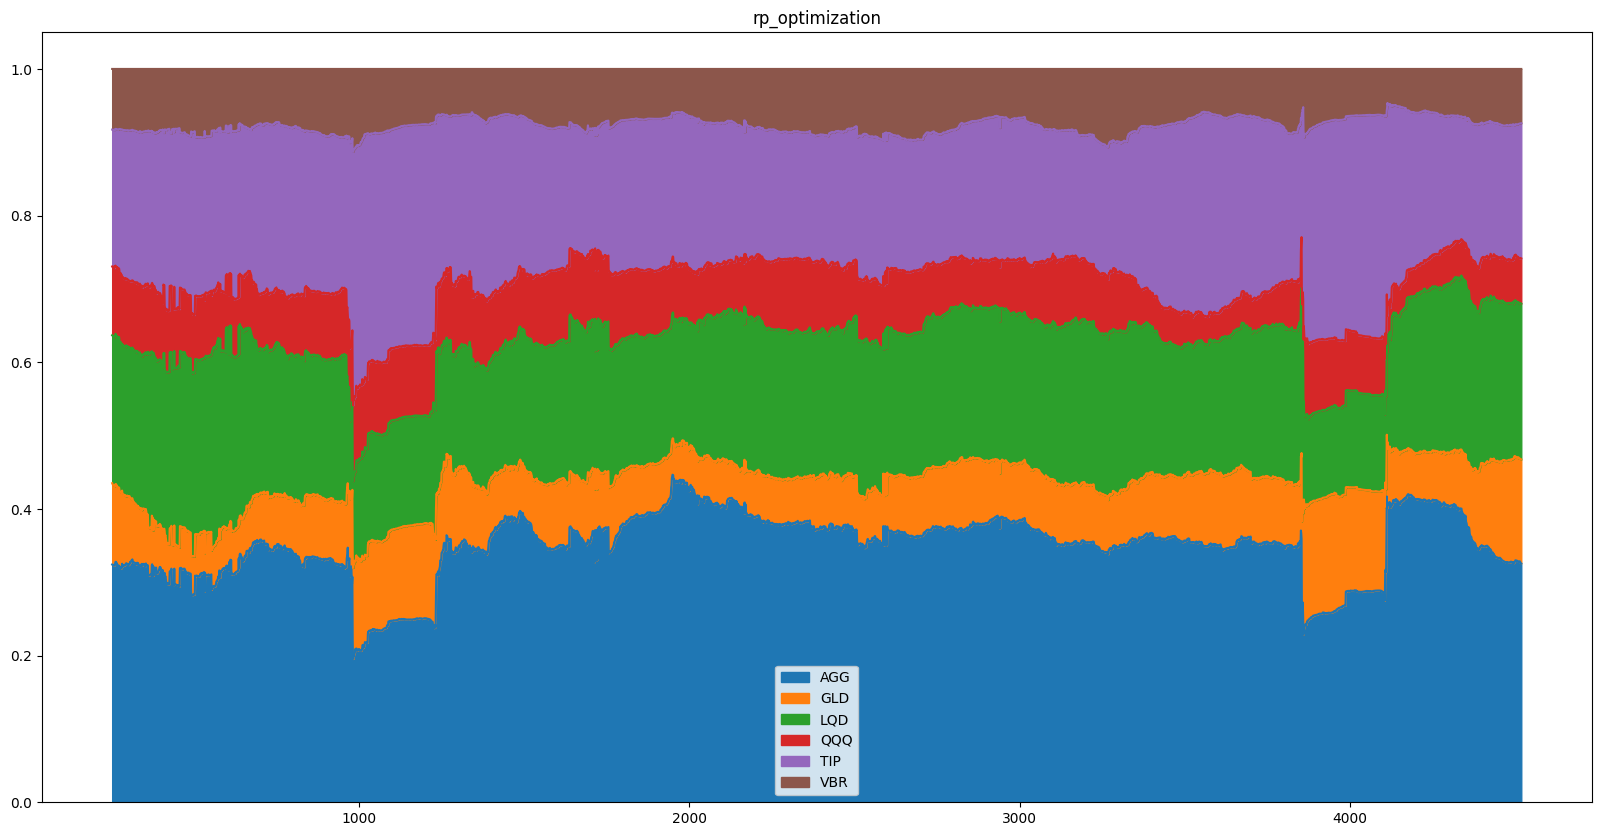

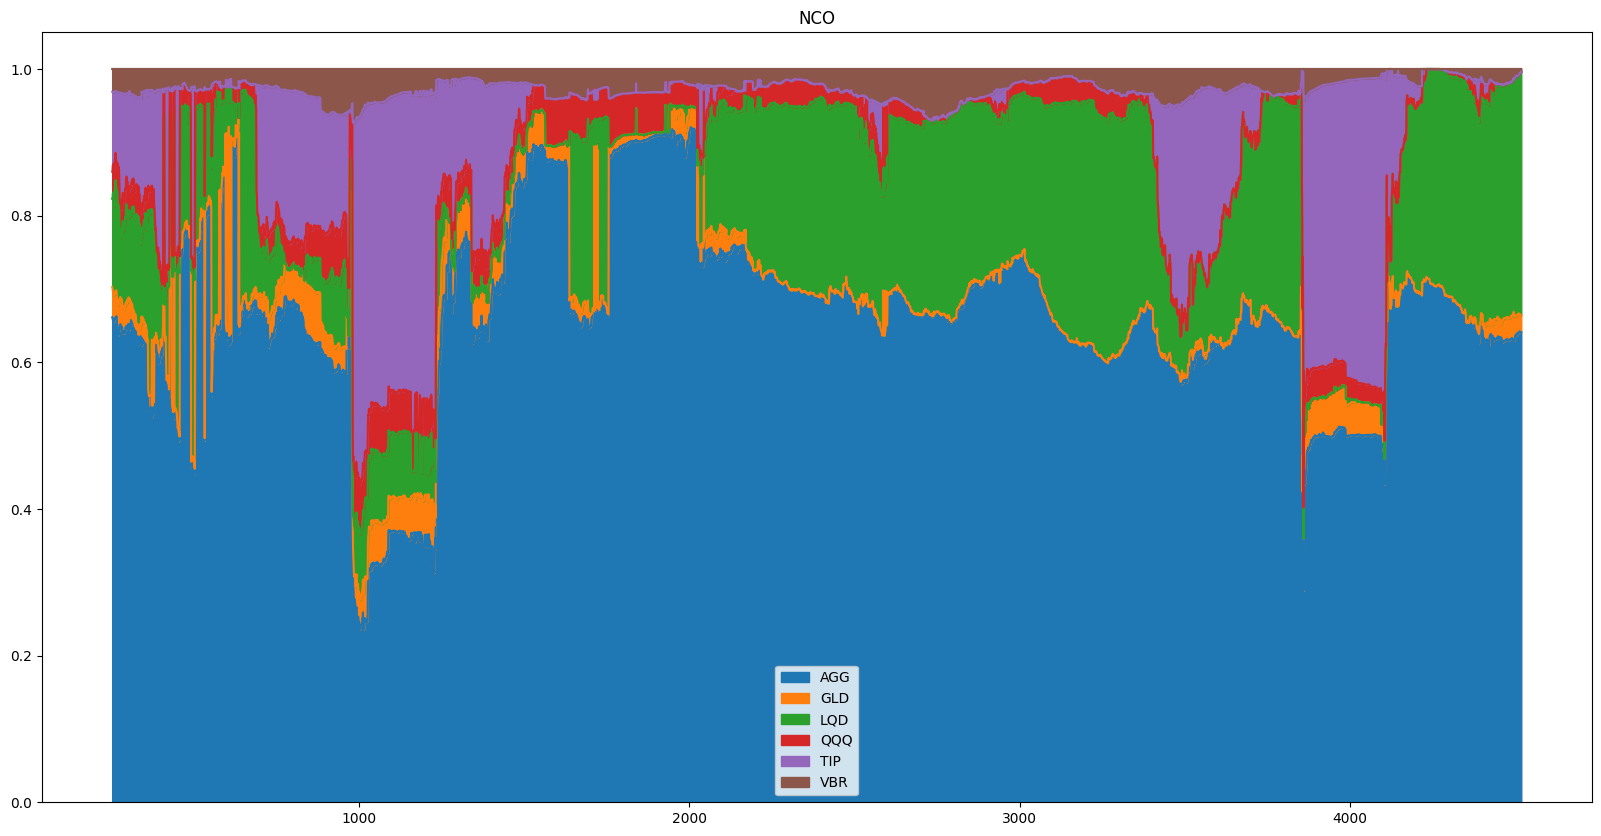

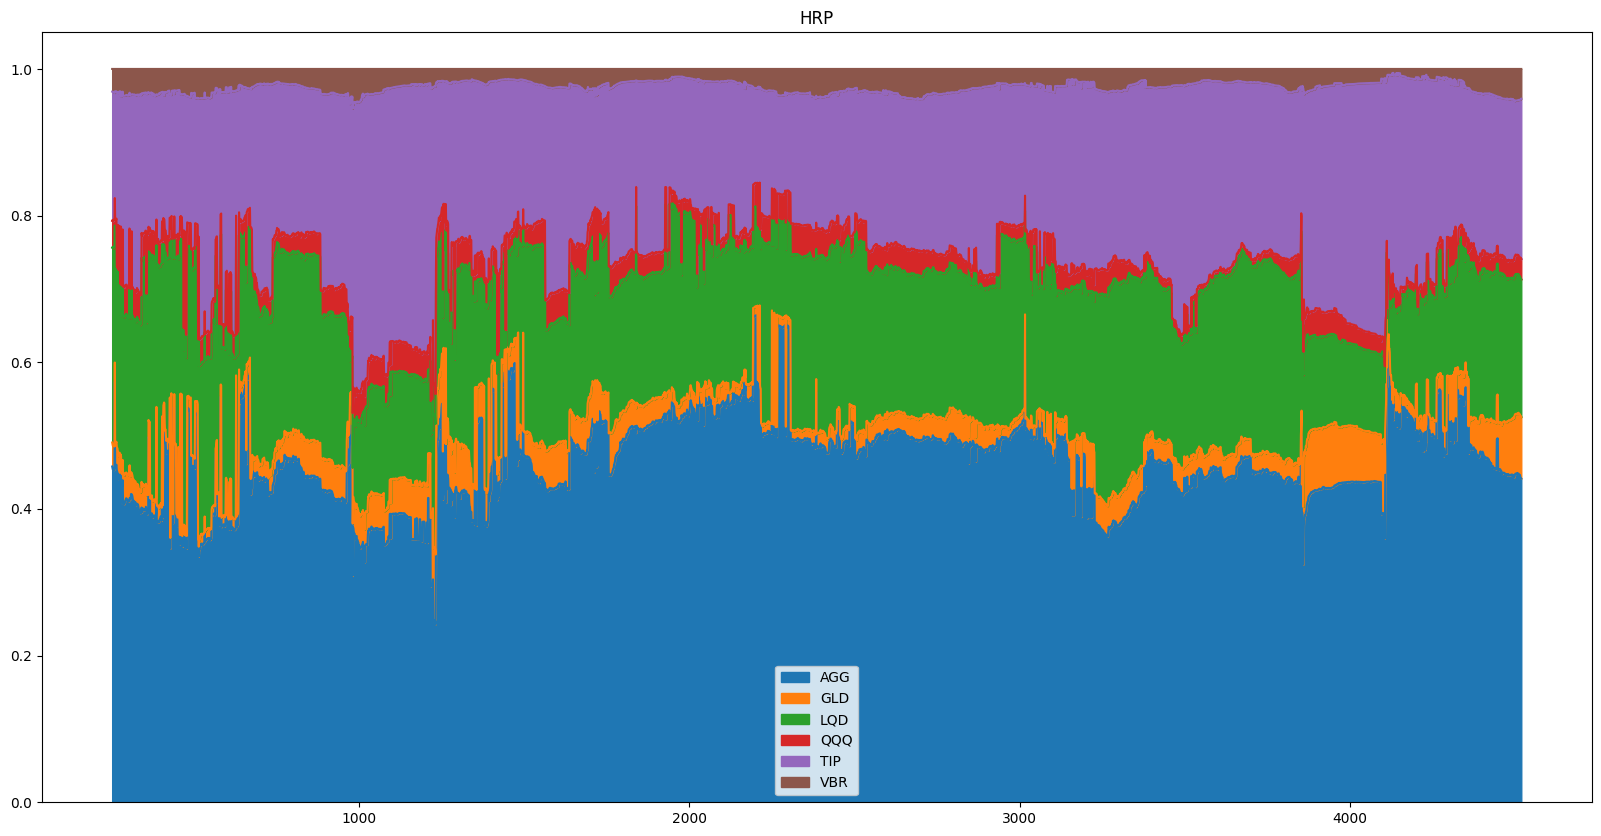

In [14]:
for model in model_list:
    t = pd.DataFrame([i[model] for i in weights_port.values()], index = weights_port.keys())
    t.index = t.index.astype(int)
    t.plot(kind = "area",stacked = True, figsize = (20,10))
    plt.title(model)
    plt.show()

In [15]:
def risks_meansure(ret_b):
    return rk.MAD(ret_b),  \
        rk.Kurtosis(ret_b), \
        rk.SemiKurtosis(ret_b), \
        rk.VaR_Hist(ret_b), \
        rk.WR(ret_b), \
        rk.LPM(ret_b), \
        rk.Entropic_RM(ret_b), \
        rk.RLVaR_Hist(ret_b), \
        rk.UCI_Abs(ret_b), \
        rk.GMD(ret_b), \
        rk.TG(ret_b), \
        rk.RG(ret_b), \
        rk.CVRG(ret_b)

def risks_stats_asset_univ(uni_ret):
    '''
    calc some stats about the asset universe
    Parameters
    ----------
    uni_ret : dataframe
        THE UNIVERSE' RETURNS', for each asset. Assumes no NA! 

    Returns
    -------
    a tuple of 4 values, as specified in strat
    '''
    risk_df = np.empty((len(uni_ret.columns), 13))
    for i, col in enumerate(uni_ret.columns):
        risk_df[i] = risks_meansure(uni_ret[col])
    
    return list(risk_df.mean(axis = 0)) + list(risk_df.std(axis = 0))

In [16]:
'''PART 2: CREATING X AND Y DATASET FOR XGB
        if index is at 1026, perf_period=2, sharpe_period=3
        ret_b computes data from 1024 to day 1025, perf_period number of days backwards
        ret_f computes data from 1026 to 1028, sharpe_period number of days backwards

    X DATA (FEATURES):
        features are computed using returns from perf_period backwards (ret_b)
        features like semi_ERC with 'ERC' or 'HRP' attached at the end, measure ret_b for that strategy only
        asset universe stats measure ret_b for each asset individually, and combines these stats
        while mean/std_corr, cond, coph, det measure data regarding that date's corr matrix
        
        SEMI_STD_ERC/HRP:
            measures the std of returns below mean return only
        
        AVE_RETURN_ERC/HRP:
            get mean return of that portfolio's daily returns in perf_period
        
        REALISED_VOLATILITY_ERC/HRP:
            alternative measure of variance
            
        MAXIMUM DRAWDOWN:
            longest consecutive decrease (peak-to-trough) in perf_period, divided by the peak
       
        MONTHLY ASSET UNIVERSE STATS:
            mean_assets_mean: get mean return in each asset. Take average across assets
            std_assets_mean: get std return in each asset. Take average across assets
            mean_assets_SD: get mean return in each asset. Take std across assets
            std_assets_SD: get std return in each asset. Take std across assets
            mdd_assets_mean: get mdd in each asset. Take ave across assets
            mdd_assets_SD: get mdd in each asset. Take std across assets
        
        MEAN_CORR, STD_CORR:
           take the mean and std of upper triangular elems in correlation matrix. Measures
           average correlation btwn assets and how varied these corr are
        
        CONDITION NUMBER, DETERMINANT:
            some characteristics about the correlation matrix
        
        COPHENETIC CORRELATION COPEFFICIENT:
            measures quality of clustering
        
        Conditional Value at Risk (CVaR)
        First or Second Lower Partial Moment of a returns series
        Average Drawdown (ADD)
        Drawdown at Risk (DaR) of a returns
        Conditional Drawdown at Risk (CDaR)
        Ulcer Index (UCI)
        Sharpe Ratio (SR)
        Sortino Ratio (SOR)
        Omega Ratio (ORM)
    
    Y DATA (LABELS): 
        SHARPE_ERC/HRP:
            sharpe at index 1026 gives sharpe ratio from day1026 to day 1027 if sharpe_period=2
            estimated using daily returns
'''

risk_list = ["MAD", "Kurtosis", "SemiKurtosis", "VaR_Hist", "WR", "LPM", "Entropic_RM", "RLVaR_Hist", "UCI_Abs", "GMD", "TG", "RG", "CVRG"]
general_risk_list = [r + "_mean" for r in risk_list] + [r + "_sd" for r in risk_list]
portfolio_specific_data = [pd.DataFrame(index=index_int,
    columns=[
        'sharpe',
        'semi',
        'ave_return',
        'rea_vol', 
        'mdd',
        *risk_list
        ],
    dtype='float64') for _ in model_list]

general_data=pd.DataFrame(index=index_int,
                  columns=[
                            'mean_assets_mean', 'std_assets_mean',
                            'mean_assets_SD', 'std_assets_SD',
                            'mdd_assets_mean', 'mdd_assets_SD',
                            'mean_corr',
                            'std_corr',
                            'cond',
                            'coph_coef',
                            'det', *general_risk_list],
                  dtype='float64'
)

'''Generate portfolio returns(series) for ERC and HRP separately'''


port_ret_list = []
for model in model_list:
    model_ret = port_ret(
        pd.DataFrame([weight_i[model] for weight_i in weights_port.values()], index = weights_port.keys()).T,
        returns,
        index_
    )
    port_ret_list.append(model_ret)

#both are one month, which is 21 trading days
#I believe sharpe_period should represent the duration between each rebalancing date
perf_period=21
sharpe_period=21

'''
Weird indexing to make it such that it doesnt run into NaN values, yet fill data as much as possible
because model needs to calc perf_period backwards and sharpe_period forwards worth of data

first day of data is the first elem of index_ + perf_period number of days
last day of data is the last elem of index_ - sharpe_period number of days (final i that range iterates over)
u add +1 to range because iloc functions like range, last elem in range is len(returns.index)-sharpe_period
'''
def compute_features(i):
    '''calc ERC first'''
    for port_i, port_ret_i in enumerate(port_ret_list):
    #ret_f is returns (sharpe_period) days forwards, INCLUDING current date
        ret_f=port_ret_i.iloc[i:i+sharpe_period]
        sharpe = get_sharpe(ret_f,'daily')
        
        portfolio_specific_data[port_i].at[ i, 'sharpe'] = sharpe
        
        #ret_b is returns (perf_period) days backwards, EXCLUDING current date
        ret_b=port_ret_i.iloc[i-perf_period:i]
        portfolio_specific_data[port_i].loc[ i, ['semi','ave_return','rea_vol','mdd']] = \
                        semi_std(ret_b) ,ret_b.dropna().mean(), rea_vol(ret_b), mdd(ret_b)

        portfolio_specific_data[port_i].loc[i, 
            risk_list] = \
            risks_meansure(ret_b)

    '''get stats on all assets'''
    #first compute mean and std vertically for each asset, then do another mean horizontally
    general_data.loc[ i , ['mean_assets_mean', 'std_assets_mean',
                          'mean_assets_SD', 'std_assets_SD',
                          'mdd_assets_mean', 'mdd_assets_SD',] ]\
            =stats_asset_univ(returns.iloc[i-perf_period:i])
    
    '''calc stats based on Correlation matrix(same for both HRP and ERC)'''
    general_data.loc[ i , ['mean_corr','std_corr','cond','det'] ] = stats_corr(corr[i])
    
    '''add in cophenetic stats'''
    general_data.loc[ i , 'coph_coef'] = coph[i]
    
    general_data.loc[ i , general_risk_list ]\
            = np.array(risks_stats_asset_univ(returns.iloc[i-perf_period:i]))


In [17]:

# for i in tqdm(range(index_[0]+perf_period, len(returns.index)-sharpe_period+1)):
#     compute_features(i)

In [18]:
import joblib
name = "full_port_{x}_add.pkl"
x_name = name.format(x="X")
y_name = name.format(x="y")
X = joblib.load(x_name)
y = joblib.load(y_name)

In [228]:
'''PART 3: TRAINING XGBOOST: CREATE MPM CHOICES
trng period is the number of data points that XGB considers. 
It also is the number of days that XGB looks back, since each day has one data point
'''
#choose trng_period in number of days
trng_period=252 * 8
embrago_period=2
val_period=5
#indexes of ret where weights_MPM will have data
#since index_ is ascending order, simply pick the suitable indexes
index_trng=[x for x in index_ if x > index_[0]+perf_period+trng_period ]
pref_list = ["train_MAPE",
    "train_corr",
    "val_MAPE",
    "val_corr",
    "test_pred",
    "test_true"
]
#prep the feature importances
feat_impt = pd.DataFrame(columns=X[0].columns, index=index_trng, dtype='float64')
test_shap_impt = pd.DataFrame(columns=X[0].columns, index=index_trng, dtype='float64')
test_shap_impt_base = pd.DataFrame(columns = ["base"], index=index_trng, dtype='float64')

pred_sharpe = pd.DataFrame(columns=model_list, index=index_trng, dtype='float64')
test_sharpe = pd.DataFrame(columns=model_list, index=index_trng, dtype='float64')
df_pref_models = pd.DataFrame(columns = pref_list, index=index_trng, dtype='float64')
weights_stregies = "select_best" #"select_best" or "weights_avg"
#build MPM weight dict
weights_MPM={}
best_model_array = []

# create model instance
pre_params = dict(
    # tree_method='gpu_hist',
    # booster='gbtree',
    # lambdarank_num_pair_per_sample=5, 
    # objective="rank:ndcg", 
    # lambdarank_pair_method="topk",
    n_estimators = 100,
    # verbosity = 0, 
    # num_boost_round=100,
    # eval_metric='ndcg@3'
    early_stopping_rounds=50, 
    device="cuda"
)

post_params = dict(
    # tree_method='gpu_hist',
    # booster='gbtree',
    # lambdarank_num_pair_per_sample=15, 
    # objective="rank:ndcg", 
    # lambdarank_pair_method="topk",
    n_estimators = 200,
    # verbosity = 0, 
    # num_boost_round=100,
)
def get_X_y(slice_):
    X_all = []
    y_all = []
    qid = []
    for model_i in range(len(model_list)):
        X_all.append(X[model_i].loc[slice_])
        y_all.append(y[model_i].loc[slice_])
        qid.extend(range(len(X_all[0])))
    X_all, y_all, qid = pd.concat(X_all, axis=0), pd.concat(y_all, axis=0), np.array(qid)
    sorted_idx = np.argsort(qid)
    X_all = X_all.iloc[sorted_idx, :]
    qid = qid[sorted_idx]
    
    y_all = pd.Series(y_all.to_frame().groupby(qid).rank(ascending=False, method='average').astype(int).values.ravel())
    return X_all, y_all, qid

for i in tqdm(index_trng): #these are integer indexes where MPM strat choosing occurs
    #note that loc includes last elem! make sure not to include the X you want to predict
    train_test_slice = slice(i-trng_period, i-1)
    train_slice = slice(i-trng_period, i-val_period-embrago_period)
    val_slice = slice(i-val_period, i-1)
    
    # get training data
    train_test_X, train_test_y, group_train_test = get_X_y(train_test_slice)
    train_X, train_y, group_train = get_X_y(train_slice)
    
    #get validation data
    val_X, val_y, group_val = get_X_y(val_slice)
    
    #get test data
    test_X, test_y, group_test = get_X_y([i])
    
    
    #fit model
    weights = 1 / (np.arange(group_train[-1]+1, 0, -1))
    reg = XGBRanker(**pre_params)
    reg.fit(train_X, train_y, eval_set = [(val_X, val_y)], verbose=False, qid=group_train, eval_qid=[group_val], sample_weight=weights)
    sharpe_pred_val = reg.predict(val_X)
    
    
    weights = 1 / (np.arange(group_train_test[-1]+1, 0, -1))
    post_reg = XGBRanker(**post_params)
    post_reg.fit(train_test_X, train_test_y, xgb_model = reg, qid=group_train_test, sample_weight=weights)
    
    #make prediction on ith month
    # sharpe_pred_train = reg.predict(data_dmatrix)
    sharpe_pred_test = post_reg.predict(test_X)
    
    # performance on validation set and test set
    pred_sharpe.loc[i] = sharpe_pred_test
    test_sharpe.loc[i] = test_y.values


    df_pref_models.loc[i, "val_corr"] = pd.DataFrame([val_y.to_numpy(), sharpe_pred_val], index = ["true", "pred"]).T.groupby(group_val).apply(lambda x: spearmanr(x["true"], x["pred"])[0]).mean()
    
    # feature importance and shap values
    
    # explainer = shap.Explainer(post_reg )
    # val_shap_values = explainer(val_X)
    explainer = shap.Explainer(post_reg )
    test_shap_values = explainer(test_X)
    
    feat_impt.loc[i] = post_reg .feature_importances_
    # shap_impt[model_i].loc[i] = np.mean(np.abs(val_shap_values.values), axis = 0)
    test_shap_impt.loc[i] = test_shap_values[0].values
    test_shap_impt_base.loc[i] = test_shap_values[0].base_values
    
    #get the best strategy
    if weights_stregies == "weights_avg":
        weights = np.array(pred_sharpe.loc[i, :]).flatten()
        weights[weights < 0] = 0
        if np.sum(weights) == 0:
            best_model = np.zeros(returns.shape[1])
        else:
            best_model = np.average([weights_port[i][model_list[model_i]] for model_i in range(len(model_list))], axis=0, weights=weights)

        # best_model = np.average([weights_port[i][model_list[model_i]] for model_i in range(len(model_list))], axis=0, weights=weights)
    elif weights_stregies == "select_best":
        best_model = weights_port[i][model_list[np.argmax(pred_sharpe.loc[i, :])]]
    
    weights_MPM[i] = best_model
    best_model_array.append(model_list[np.argmax(pred_sharpe.loc[i, :])])

100%|██████████| 105/105 [02:58<00:00,  1.70s/it]


In [229]:
post_best_model_array = []
weights_MPM = {}
for i in index_trng:
    t = pred_sharpe.loc[i, :]
    current_best = list([t[t ==np.max(t)].index])[0]

    post_best_model_array.append(current_best)
    # average
    weights_MPM[i] = np.average([weights_port[i][model_i] for model_i in current_best], axis=0)

(array([86.,  0.,  7.,  0.,  3.,  0.,  5.,  0.,  2.,  2.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

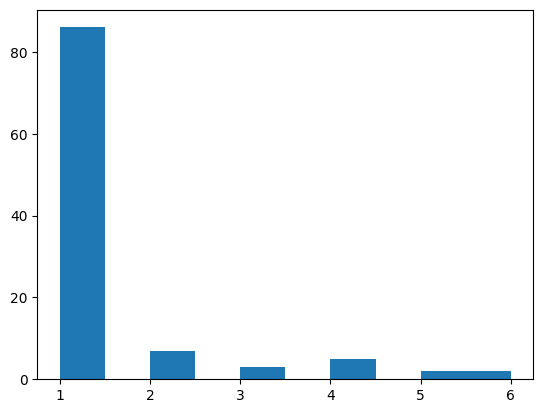

In [230]:
plt.hist(list(map(len, post_best_model_array)))

wc_optimization     22
optimization        20
NCO                 19
rp_optimization     15
HRP                 15
owa_optimization    14
dtype: int64


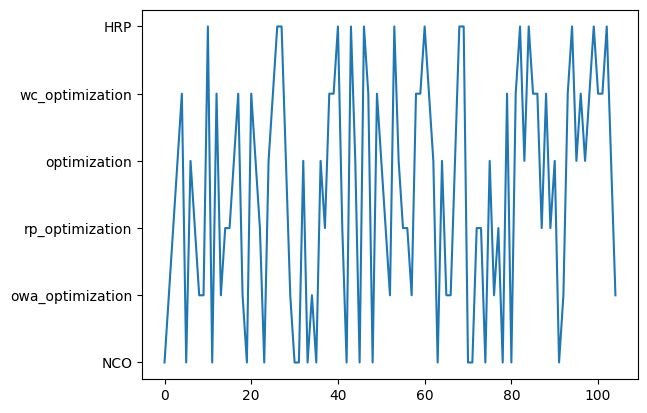

In [231]:
t = pd.Series(best_model_array)
print(t.value_counts())
plt.plot(best_model_array);


# Performance Report

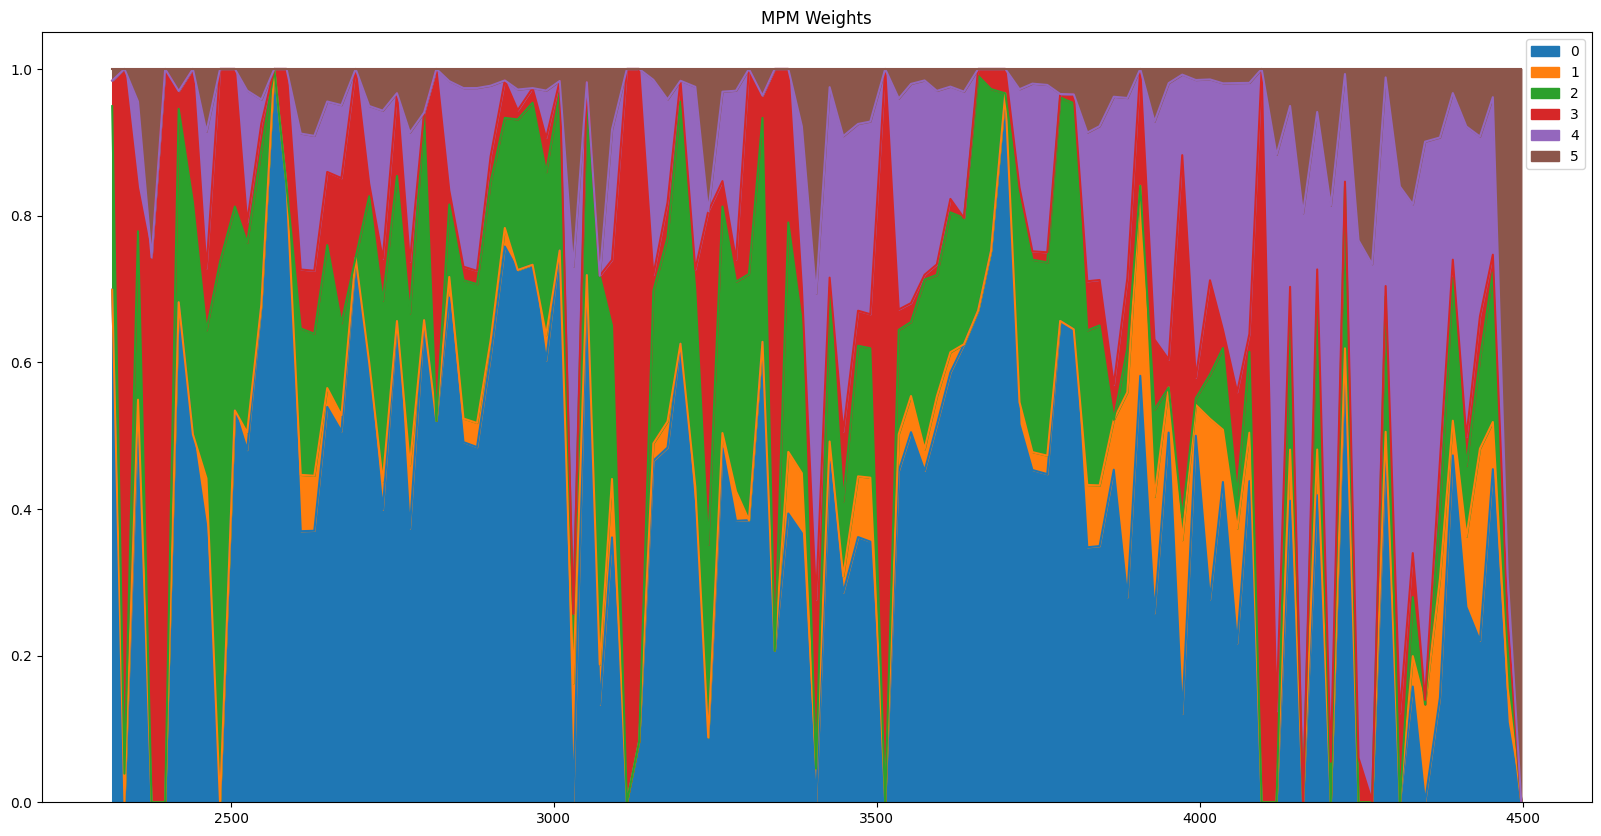

In [232]:
pd.DataFrame(weights_MPM).T.plot(kind = "area",stacked = True, figsize = (20,10))
plt.title("MPM Weights")
plt.show()

In [233]:
def port_ret(weights, ret, index_, fee_rate = 0.0000):
    '''
    this function applies a set of weights to daily returns of an asset universes
    and creates a portfolio return. note that it makes use of the theoretical property that
    ret(portfolio)= sum[asset_weight * ret(asset)]
    
    Parameters
    ----------
    weights : dictionary
        keys are the integer index of returns while each item is a set of weights for that day
        e.g.
        1105: [w1,w2,w3]
        1206: [w1_new,w2_new,w3_new]
        This will mean that weight applies on ret from 1105 to 1205, and 1206 is a diff set of weights
    ret :  a dataframe, DAILY RETURNS OF EACH TICKER
    index_ : list
        These are integer indexes of ret, where REBALANCING(CHOOSING ERC/HRP) happens
        note that index_ may be a subset of the index of weights
        because XGboost needs some months of data, can only start ltr

    Returns
    -------
    series
        daily portfolio returns, COMBINED into one value
        note that port_returns will automatically make nan all the returns up to the first date in index_
    '''
    
    ret=ret.copy()
    pred_w = weights[index_[0]].to_numpy()
    for i in range(len(index_)):
        if i!=len(index_)-1: #if the index is not the last index
            r_w = weights[index_[i]].to_list() * ret.iloc[index_[i]:index_[i+1]]
            
            w = weights[index_[i]].to_numpy()
            fee = np.sum(np.abs(w - pred_w)) / 2 * fee_rate
            pred_w = w
            
            ret.iloc[index_[i]:index_[i+1]] = r_w - fee
        else: #if last number in index_, just apply weights all the way to last row
            ret.iloc[index_[i]:]=weights[index_[i]].to_list()*ret.iloc[index_[i]:]
    #sum all the returns horizontally
    #note that if rows are NaN, summing will make them zero!!
    ret=ret.sum(axis=1)
    #make all rows nan up to first rebalancing date, not including first date
    ret.iloc[:index_[0]]=np.nan
    return ret #will contain nan, not fully filled

In [234]:
'''PART 4: FINAL BACKTEST

Measures of performance: 
1. Cumulative Return
2. Compound Annual Growth Rate
3. Annualised Sharpe Ratio constructed from daily returns
4. Annualised Sharpe Ratio constructed from monthly returns
5. Annualised Sharpe Ratio constructed from yearly returns

Important Variables:
    comp: a dataframe containing performance metrics across strategies
    perf: a float, the performance gain measured by Sharpe_MPM compared to Average(Sharpe_ERC and Sharpe_HRP)
    
    pr_df: the dataframe containing daily returns for each strategy
    feat_impt: the dataframe containing feature importances
    uni_corr: dict, contains corr matrix, mean of corrs and the std of corrs

'''
weights_ALL = {
    model: pd.DataFrame([wp[model] for _, wp in weights_port.items()], index = weights_port.keys(), columns = returns.columns).loc[weights_MPM.keys()] 
        for model in model_list
}
weights_ALL = {**weights_ALL, 
               "MPM": pd.DataFrame([weights_MPM[i] for i in weights_MPM.keys()], index = weights_MPM.keys(), columns = returns.columns)
}
keys = list(weights_ALL.keys())
#portfolio prices
pr_df=pd.DataFrame([],columns=keys)

#display results as dataframe
comp=pd.DataFrame(columns=['Cumulative Return',
                        'Compound Annual Growth Rate',
                         'Annual Sharpe(Daily)',
                         'Annual Sharpe(Monthly)',
                         'Annual Sharpe(Yearly)'],
                  index=keys)

#get performance metrics
for strat in keys:
    pr=port_ret(weights_ALL[strat].T, returns, index_trng).dropna()
    #update portfolio returns
    pr_df[strat]=pr
    #update values
    comp.loc[strat]=[cum_ret(pr),
                   cagr(pr),
                   get_sharpe(pr,'daily'),
                   get_sharpe(pr,'monthly'),
                   get_sharpe(pr,'yearly')]

<Axes: xlabel='Date'>

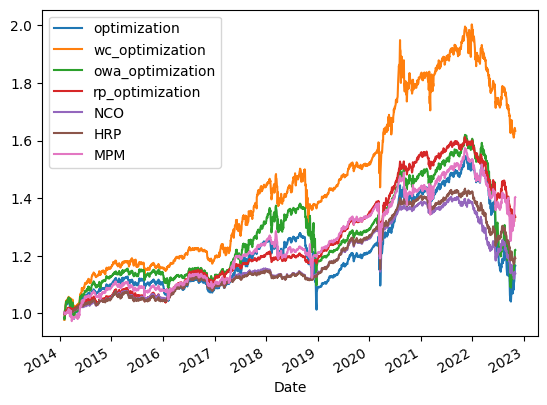

In [235]:
port = (pr_df+1).cumprod()
port.plot()

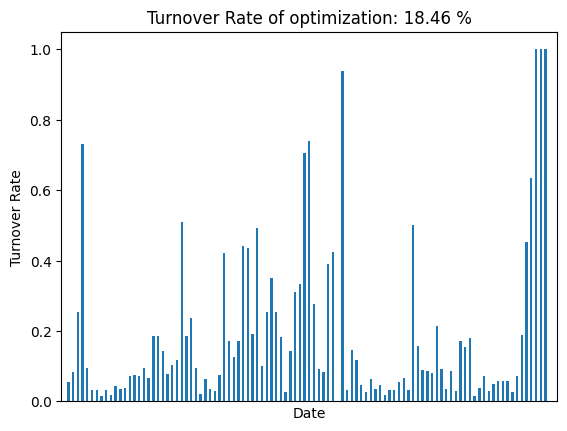

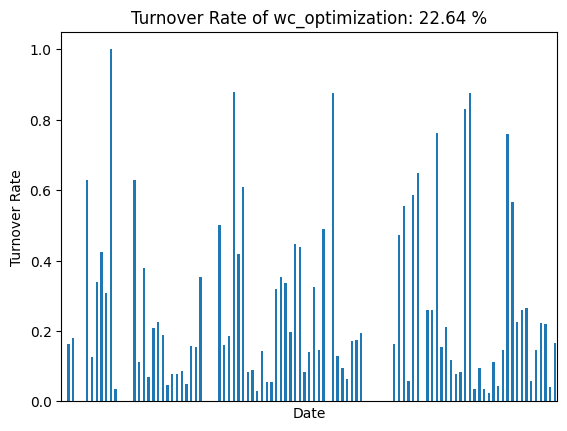

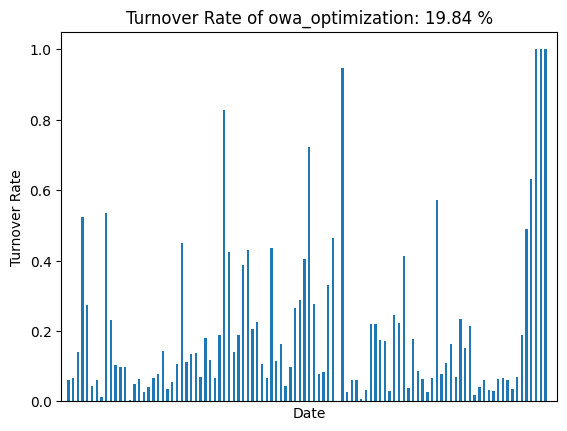

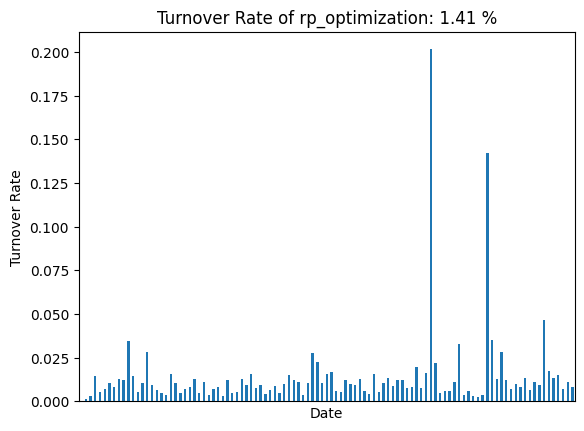

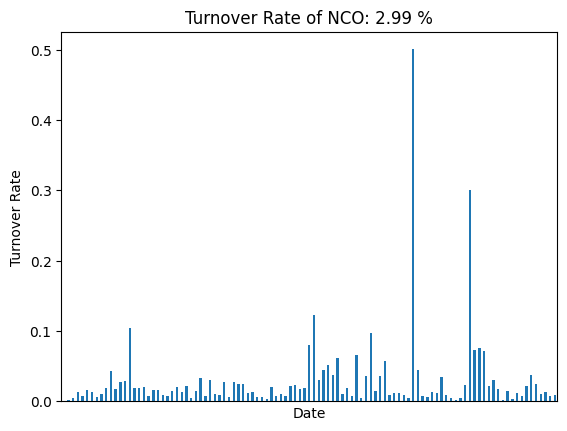

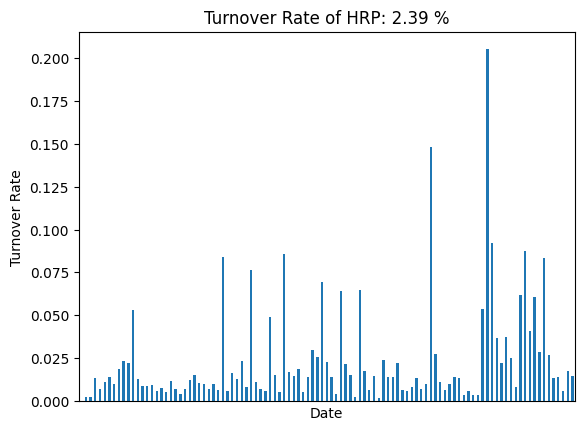

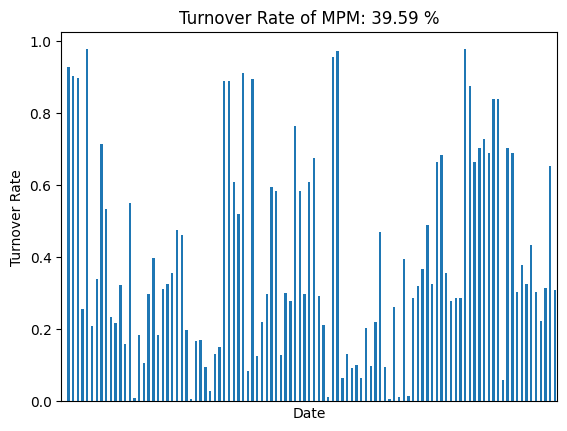

In [236]:
# turnover rate
tr_rate = {}
for model in weights_ALL.keys():
    weight_diff = weights_ALL[model].diff().abs().sum(axis=1) / 2
    tr_rate[model] = weight_diff
    turnover_rate = weight_diff.mean()
    weight_diff.plot(kind = "bar", xticks = [], xlabel = "Date", ylabel = "Turnover Rate", title = f"Turnover Rate of {model}: {turnover_rate *  100:.2f} %")
    plt.show()

## Feature importances

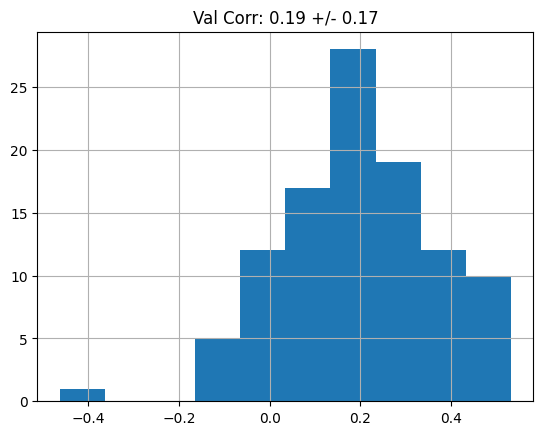

In [237]:
m = df_pref_models["val_corr"].mean()
side = df_pref_models["val_corr"].std()
df_pref_models["val_corr"].hist(bins = 10)
plt.title(f"Val Corr: {m:.2f} +/- {side:.2f}")
plt.show()

In [238]:
max_sharpe_port_all = [np.argmax(pred_sharpe.to_numpy(), axis = 1), np.argmax(test_sharpe.to_numpy(), axis = 1)]
mean_pred_acc = max_sharpe_port_all[0] == max_sharpe_port_all[1]
print(f"model correct prediction accuracy: {np.mean(mean_pred_acc) * 100:.2f} % (over {1/len(model_list) * 100:.2f} % baseline)")

model correct prediction accuracy: 20.95 % (over 16.67 % baseline)


                  precision    recall  f1-score   support

    optimization       0.20      0.15      0.17        20
 wc_optimization       0.17      0.18      0.17        22
owa_optimization       0.12      0.07      0.09        14
 rp_optimization       0.27      0.27      0.27        15
             NCO       0.25      0.32      0.28        19
             HRP       0.21      0.27      0.24        15

        accuracy                           0.21       105
       macro avg       0.20      0.21      0.20       105
    weighted avg       0.20      0.21      0.20       105



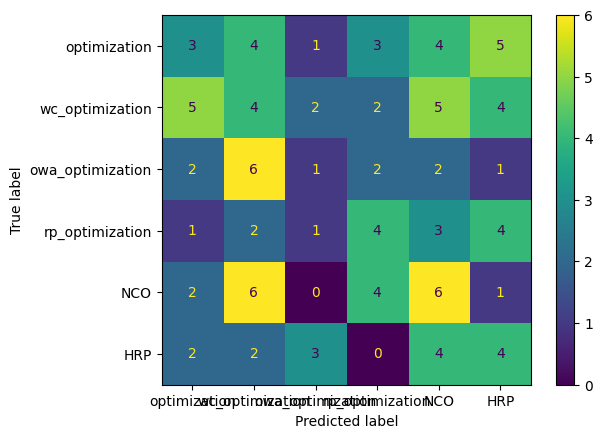

In [239]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

print(classification_report(max_sharpe_port_all[0], max_sharpe_port_all[1], target_names = model_list))
ConfusionMatrixDisplay(confusion_matrix(max_sharpe_port_all[0], max_sharpe_port_all[1]), display_labels = model_list).plot()

In [240]:
print("how well it order the portfolio relative to each other:", pred_sharpe.T.corrwith(test_sharpe.T, method = "spearman").mean())
# print(gt.corrwith(pred, method='spearman').value_counts(normalize=True))

how well it order the portfolio relative to each other: -0.016972941258325127


In [176]:
from matplotlib import colormaps
cmap = colormaps['tab10']

In [177]:
val = test_shap_impt.abs().max().sort_values(ascending = False).index[:10]

<Axes: >

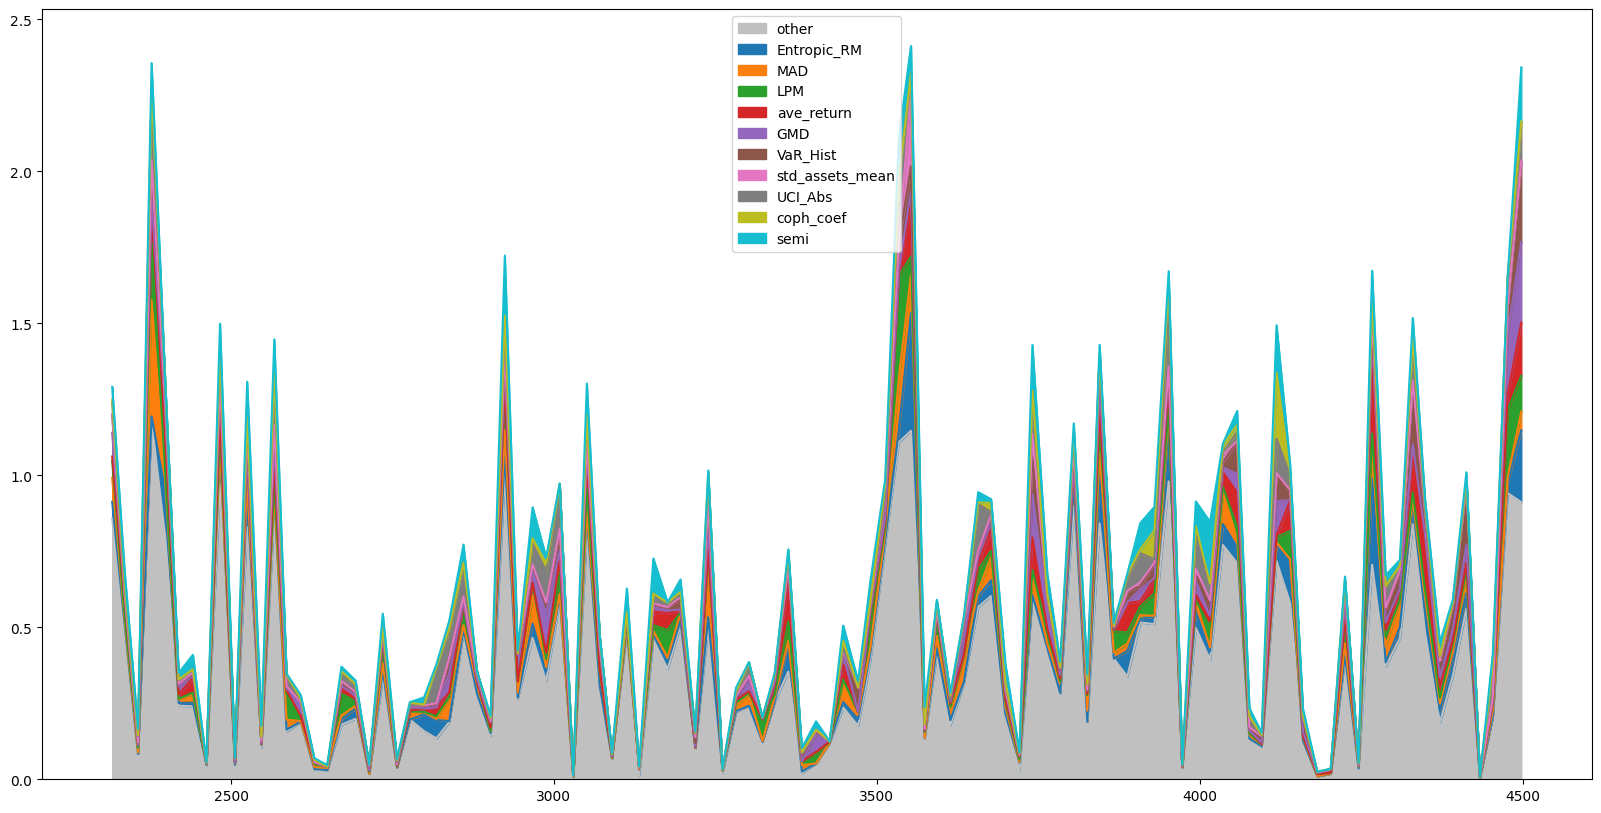

In [178]:
t = test_shap_impt.abs().copy()
mask = list(set(test_shap_impt) - set(val))
t["other"] = t[mask].sum(axis = 1)

t[["other"] + list(val)].plot(legend = True, stacked=True, kind = "area", figsize = (20,10), color = ["silver"] + list(cmap.colors))

<Axes: >

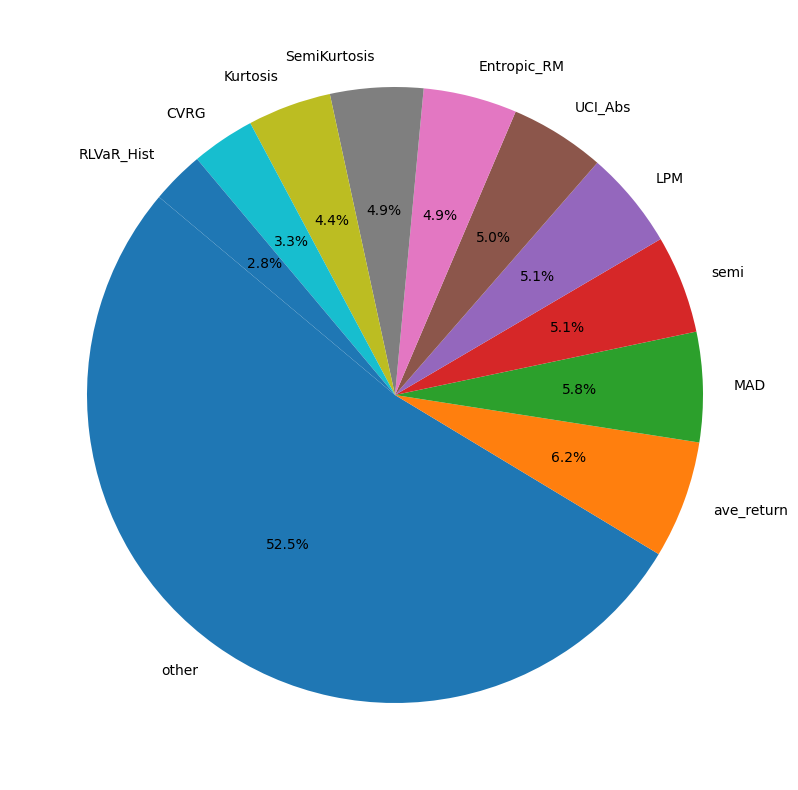

In [107]:
t[["other"] + list(val)].abs().mean().sort_values(ascending = False).plot(kind = "pie", figsize = (10,10), autopct='%1.1f%%', startangle=140)

In [108]:
contribution = t[list(val)].abs().mean().sum() / t[["other"] + list(val)].mean().sum()
print(f"contribution of top 10 features: {contribution * 100:.2f} %")

contribution of top 10 features: 47.53 %


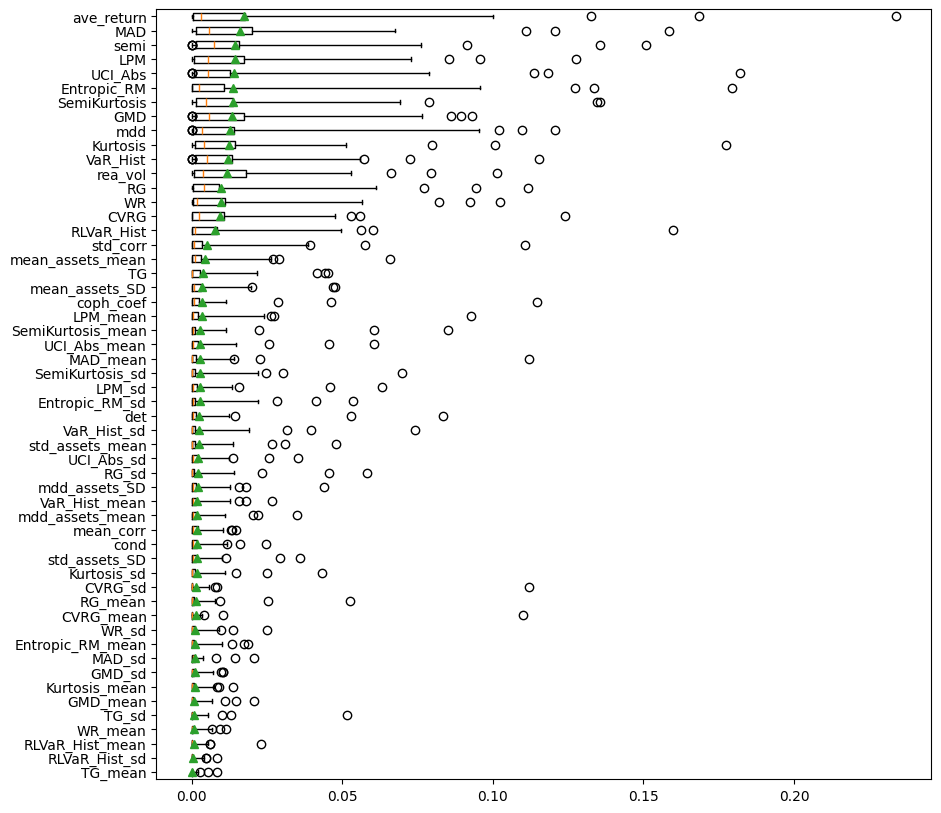

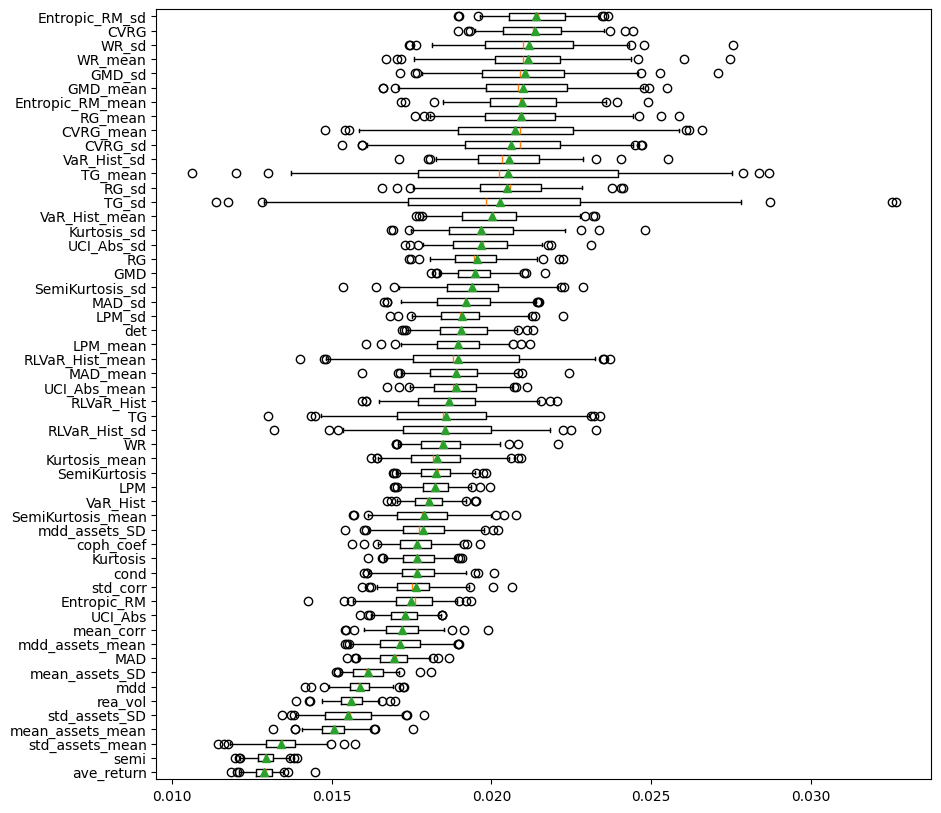

In [109]:
'''Plotting feature importance (boxplot)'''
#first sort feat_impt's columns, in terms of descending mean.
#i.e. leftmost column has highest mean
features_importance_all = [test_shap_impt, feat_impt]
for feature in features_importance_all:
    fig, axs = plt.subplots(figsize=(10, 10))
    feat = feature.abs().mean().sort_values()
    feat_plot = feature.abs().dropna().reindex(feat.index, axis=1)
    #whiskers cover 5th to 98th perc of data
    axs.boxplot(x=feat_plot,vert=False,labels=feat_plot.columns,whis=(2,98),showmeans=True)
    fig.show()

In [110]:
shap_imp_cor = test_shap_impt.abs().mean().to_frame().corrwith(feat_impt.abs().mean())[0]
print(f"correlation between feature importance of SHAP and feature importance of XGB: {shap_imp_cor}")

correlation between feature importance of SHAP and feature importance of XGB: -0.48134732997434876


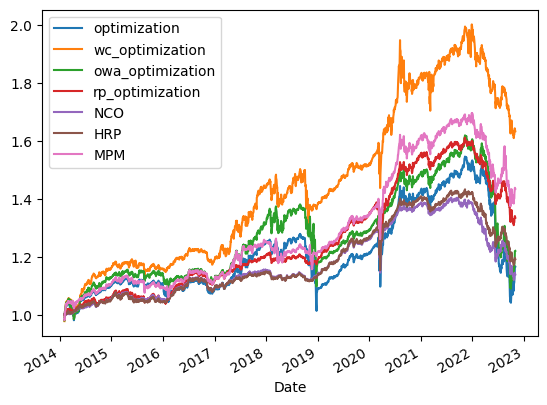

In [138]:
#show portfolio price history for strategies
port = (pr_df+1).cumprod()
port.plot()

'''Examining this asset universe, using Correlation matrix of ALL historical returns'''
uni_corr_stats=stats_uni_corr(returns.dropna())

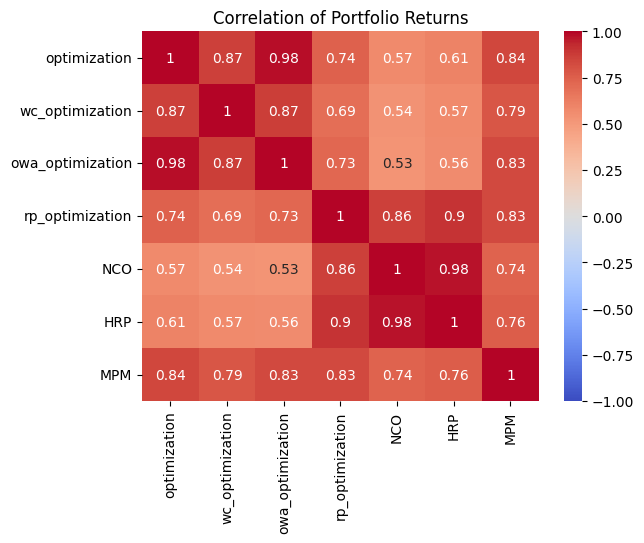

In [112]:
import seaborn as sns
sns.heatmap(pr_df.corr(method = "spearman"), vmin = -1, vmax = 1, annot = True, cmap = "coolwarm")
plt.title("Correlation of Portfolio Returns")
plt.show()

In [113]:
# drawdown =  1 - port.div(port.cummax())
# drawdown.expanding().max().max(axis = 0)

In [218]:
# annualised volatility
vol = pr_df.groupby(pr_df.index.year).std().mean() * np.sqrt(252)
prob_sharpe = [probabilistic_sharpe_ratio(pr_df_i, sr_benchmark=0) for pr_df_i in pr_df.T.values]
skew = pr_df.skew()
kur = pr_df.kurtosis()

add_info = pd.DataFrame([prob_sharpe, vol, skew, kur], index = ["probabilitistic Sharpe", "annualised volatility", "skewness", "kurtosis"], columns = model_list + ["MPM"]).T
add_info.style.background_gradient(cmap='coolwarm')

,probabilitistic Sharpe,annualised volatility,skewness,kurtosis
optimization,0.744432,0.091240,-0.509388,14.908151
wc_optimization,0.962670,0.090343,-0.919155,11.158668
owa_optimization,0.789778,0.090775,-0.588955,13.701870
rp_optimization,0.958047,0.051549,-1.157584,22.290758
NCO,0.812479,0.047009,-1.746623,42.335591
HRP,0.884298,0.046951,-1.023678,25.001448
MPM,0.960353,0.067534,-0.715292,17.359297


There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in cagr!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 values in get_sharpe!
There exists NaN or 0 va

<Axes: xlabel='Date'>

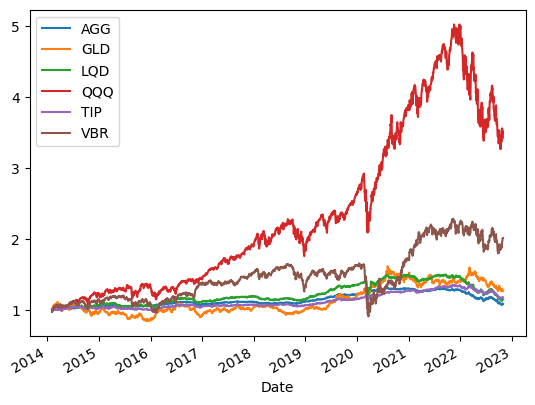

In [219]:
test_ret = returns.loc[pr_df.index[0]:pr_df.index[-1]]

asset_perf_stats = pd.DataFrame(index = test_ret.columns, columns = ['Cumulative Return', 'CAGR', 'Sharpe(Daily)', 'Sharpe(Monthly)', 'Sharpe(Yearly)'])
for asset in test_ret.columns:
    pr = test_ret.dropna()[asset]
    asset_perf_stats.loc[asset] = [cum_ret(pr), cagr(pr), get_sharpe(pr,'daily'), get_sharpe(pr,'monthly'), get_sharpe(pr,'yearly')]


(1 + test_ret.dropna()).cumprod().plot()

In [220]:
#perfomance increase of MPM against ave of ERC and HRP, made using daily sharpe estimates
col = "Annual Sharpe(Daily)"
ave = comp.loc[model_list, col].mean()
perf=( (comp.loc['MPM', col]-ave)/ave )*100
print(f"perfomance increase of MPM against the mean, made using {col} estimates {perf:.4f}%")
full_info = pd.concat([comp, add_info], axis = 1)
# set dtypes
full_info = full_info.astype(float).sort_values(by = col, ascending = False)
full_info.style.background_gradient(cmap='coolwarm').format("{:.4f}")

perfomance increase of MPM against the mean, made using Annual Sharpe(Daily) estimates 49.1216%


,Cumulative Return,Compound Annual Growth Rate,Annual Sharpe(Daily),Annual Sharpe(Monthly),Annual Sharpe(Yearly),probabilitistic Sharpe,annualised volatility,skewness,kurtosis
wc_optimization,0.6337,0.0578,0.6151,0.6904,0.8513,0.9627,0.0903,-0.9192,11.1587
MPM,0.4437,0.0429,0.6037,0.4617,0.9186,0.9604,0.0675,-0.7153,17.3593
rp_optimization,0.3349,0.0336,0.5998,0.5540,0.9366,0.9580,0.0515,-1.1576,22.2908
HRP,0.1914,0.0202,0.4111,0.4018,0.8626,0.8843,0.0470,-1.0237,25.0014
NCO,0.1388,0.0150,0.3057,0.3338,0.8218,0.8125,0.0470,-1.7466,42.3356
owa_optimization,0.2203,0.0230,0.2741,0.0972,0.5695,0.7898,0.0908,-0.5890,13.7019
optimization,0.1660,0.0177,0.2232,0.0446,0.4963,0.7444,0.0912,-0.5094,14.9082


In [118]:
asset_perf_stats.columns = comp.columns

In [119]:
#perfomance increase of MPM against ave of ERC and HRP, made using daily sharpe estimates
col = "Annual Sharpe(Monthly)"
tmp_comp = pd.concat([comp.loc[["MPM"]], asset_perf_stats], axis = 0)
ave=tmp_comp.loc[asset_perf_stats.index, col].mean()
perf=( (tmp_comp.loc['MPM', col]-ave)/ave )*100
print(f"perfomance increase of MPM against the mean, made using {col} estimates {perf:.4f}%")
# set dtypes
full_info = tmp_comp.astype(float).sort_values(by = col, ascending = False)
full_info.style.background_gradient(cmap='coolwarm').format("{:.4f}")

perfomance increase of MPM against the mean, made using Annual Sharpe(Monthly) estimates 40.6473%


,Cumulative Return,Compound Annual Growth Rate,Annual Sharpe(Daily),Annual Sharpe(Monthly),Annual Sharpe(Yearly)
QQQ,2.4814,0.1534,0.7666,0.8341,1.2874
MPM,0.4348,0.0422,0.6009,0.5515,0.7926
VBR,1.0112,0.0832,0.4813,0.4259,0.7047
TIP,0.1730,0.0184,0.3506,0.3503,0.8906
AGG,0.0803,0.0089,0.2129,0.2640,0.7880
LQD,0.1466,0.0158,0.2324,0.2495,0.6425
GLD,0.2650,0.0273,0.2613,0.2286,0.5210


# Over COVID-19 period

In [120]:
import joblib
joblib.dump(port, 'port2.pkl')
port = joblib.load('port2.pkl')

In [121]:
port

,optimization,wc_optimization,owa_optimization,rp_optimization,NCO,HRP,MPM
Date,,,,,,,
2014-02-03,0.983017,0.977482,0.980007,0.999204,1.002681,1.002381,0.981512
2014-02-04,0.988062,0.984515,0.986017,0.997822,1.000176,0.999797,0.987040
2014-02-05,0.985516,0.981966,0.983403,0.995107,0.997490,0.996839,0.984460
2014-02-06,0.995143,0.994275,0.994588,0.996971,0.997550,0.997313,0.994867
2014-02-07,1.009262,1.011745,1.010857,1.001725,1.000196,1.000497,1.010061
...,...,...,...,...,...,...,...
2022-10-25,1.138007,1.633884,1.191012,1.332680,1.134267,1.188037,1.421186
2022-10-26,1.140331,1.638040,1.193444,1.335165,1.139390,1.191088,1.424875
2022-10-27,1.145340,1.643897,1.198686,1.339173,1.144733,1.196285,1.430673


In [122]:
import plotly.express as px
import pandas as pd

fig = px.line(port, x=port.index, y=model_list[0], title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [123]:
def cal_worst(cum_returns):
    drawdown =  1 - cum_returns.div(cum_returns.cummax())
    mdd = drawdown.max(axis=0).sort_values(ascending = False) * 100
    
    mpm = mdd["MPM"]
    other = mdd.drop("MPM")
    mean_perf = (mpm / other.mean() - 1) * 100
    min_perf = (mpm / other.min() - 1) * 100
    print(f"MPM's max drawdown: {mpm:.2f} %")
    print(f"MPM's performance against mean drawdown: {mean_perf:.2f} %")
    print(f"MPM's performance against min drawdown: {min_perf:.2f} %")
    return mdd, mean_perf, min_perf

In [124]:
cum_returns = port.loc["2020-02-20":"2020-04-20"]
mdd, mean_perf, min_perf = cal_worst(cum_returns)
pd.DataFrame(mdd).T.style.background_gradient(cmap='coolwarm',vmin = min(mdd), vmax = max(mdd)).format("{:.2f} %")

MPM's max drawdown: 9.96 %
MPM's performance against mean drawdown: -17.85 %
MPM's performance against min drawdown: 1.60 %


,rp_optimization,optimization,NCO,HRP,owa_optimization,MPM,wc_optimization
0,13.85 %,13.40 %,12.97 %,12.77 %,9.96 %,9.96 %,9.81 %


In [125]:
cum_returns = port.loc["2021-12-31":]
mdd, mean_perf, min_perf = cal_worst(cum_returns)
pd.DataFrame(mdd).T.style.background_gradient(cmap='coolwarm',vmin = min(mdd), vmax = max(mdd)).format("{:.2f} %")

MPM's max drawdown: 18.85 %
MPM's performance against mean drawdown: -17.84 %
MPM's performance against min drawdown: 6.78 %


,owa_optimization,optimization,NCO,MPM,wc_optimization,rp_optimization,HRP
0,32.05 %,31.98 %,19.06 %,18.85 %,18.84 %,18.09 %,17.65 %
